In [1]:
import torch

from circuit_pruner.utils import *
from circuit_pruner.visualizer.layouts import *
#from circuit_pruner.visualizer.cnn_gui import *
from circuit_pruner.visualizer.circuit_gui import *
from circuit_pruner.visualizer.utils import *
from circuit_pruner.visualizer.featureviz import *



from circuit_pruner.utils import *
from circuit_pruner.force import *
from circuit_pruner.extraction import *
from circuit_pruner.ranks import *

import os
import plotly.offline as py
import plotly.graph_objs as go
import dash
import dash_core_components as dcc
import dash_html_components as html
import dash_daq as daq
from dash.exceptions import PreventUpdate
#import utils.dash_reusable_components as drc
import flask
import json
from dash.dependencies import Input, Output, State
from plotly.subplots import make_subplots
from flask_caching import Cache
import base64

In [2]:
#hardware
device = 'cuda:0'

from circuit_pruner.utils import load_config

config = load_config('/mnt/data/chris/dropbox/Research-Hamblin/Projects/circuit_pruner_cvpr2022/configs/alexnet_sparse_config.py')
model = config.model.to(device)



#general
import torch
import os
from copy import deepcopy
from circuit_pruner.force import setup_net_for_circuit_prune, show_model_layer_names


show_model_layer_names(model)

/home/chris/miniconda3/envs/circuit_pruner/lib/python3.7/site-packages/torch/cuda/__init__.py:125: UserWarning:


Tesla K40c with CUDA capability sm_35 is not compatible with the current PyTorch installation.
The current PyTorch install supports CUDA capabilities sm_37 sm_50 sm_60 sm_61 sm_70 sm_75 compute_37.
If you want to use the Tesla K40c GPU with PyTorch, please check the instructions at https://pytorch.org/get-started/locally/




All Layers:

features
features_0
features_1
features_2
features_3
features_4
features_5
features_6
features_7
features_8
features_9
features_10
features_11
features_12
avgpool
classifier
classifier_0
classifier_1
classifier_2
classifier_3
classifier_4
classifier_5
classifier_6

Convolutional and Linear layers:

('features_0', '  conv')
('features_3', '  conv')
('features_6', '  conv')
('features_8', '  conv')
('features_10', '  conv')
('classifier_1', '  linear')
('classifier_4', '  linear')
('classifier_6', '  linear')


['features',
 'features_0',
 'features_1',
 'features_2',
 'features_3',
 'features_4',
 'features_5',
 'features_6',
 'features_7',
 'features_8',
 'features_9',
 'features_10',
 'features_11',
 'features_12',
 'avgpool',
 'classifier',
 'classifier_0',
 'classifier_1',
 'classifier_2',
 'classifier_3',
 'classifier_4',
 'classifier_5',
 'classifier_6']

In [3]:
#feature target
# layer = 'features_10'
# unit = 241
layer = 'features_6'
unit = 222
#layer = 'features_0'
#unit = 0

feature_targets = {layer:[unit]}

t7.jpg


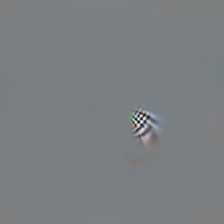

full.jpg


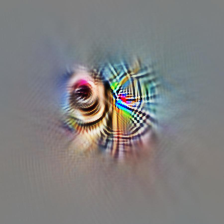

t3.jpg


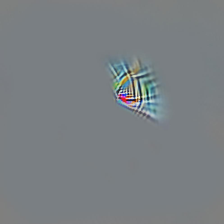

t4.jpg


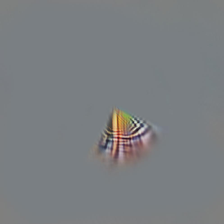

t5.jpg


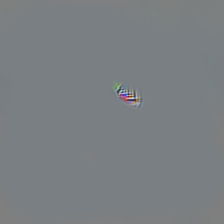

t1.jpg


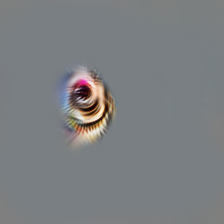

t8.jpg


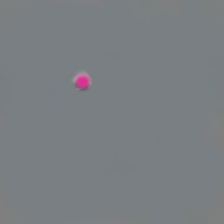

t6.jpg


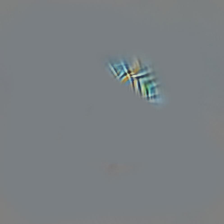

t2.jpg


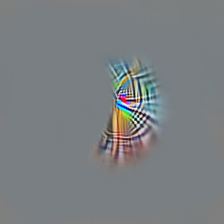

features_6 effective last layer
pruning weights
total parameters: 330624
parameters after pruning: 33063
keep ratio: 0.1
Pruning with 10 pruning steps
step 1
262625 params
step 2
208611 params
step 3
165706 params
step 4
131625 params
step 5
104554 params
step 6
83050 params
step 7
65969 params
step 8
52402 params
step 9
41624 params
step 10
33063 params
final mask: 33062/993984 params (0.03326210482261284)


In [4]:
from PIL import Image, ImageOps

image_folder = '../../image_data/sample_data/mask_featviz/features_6_222_gencircuit/'
image_files = os.listdir(image_folder)


for file in image_files:
    print(file)
    image = Image.open(image_folder+file)
    image = image.resize((224,224))
    display(image)

    
    
from circuit_pruner.data_loading import single_image_data
from torchvision import transforms
from torch.utils import data


preprocess =  transforms.Compose([
                                transforms.Resize((224,224)),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                     std=[0.229, 0.224, 0.225])])
# preprocess =  transforms.Compose([
#                                 transforms.Resize((224,224)),
#                                 transforms.ToTensor()])

#make single image data loaders
kwargs = {'num_workers': 1, 'pin_memory': True, 'sampler':None} if 'cuda' in device else {}


data_loaders = {}
for file in image_files:
    data_loaders[file] = data.DataLoader(single_image_data(image_folder+file,preprocess),
                                                batch_size=1,
                                                shuffle=False,
                                                **kwargs)
                  
        


from circuit_pruner.force import circuit_FORCE_pruning

masks = {}
ranks = {}


file = 't1.jpg'

structure='weights'

data_loader = data_loaders[file]


weight_rank, weight_mask = circuit_FORCE_pruning(model, data_loader, feature_targets = feature_targets, 
                                   T=10, keep_ratio=.1, rank_field='max',
                                   use_abs_ranks=True, return_ranks=True, structure=structure)


for i in range(len(weight_rank)):
    weight_rank[i] = weight_rank[i].to('cpu')
    weight_mask[i] = weight_mask[i].to('cpu')  

torch.cuda.empty_cache()

    


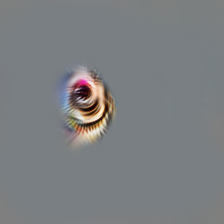

features_6 effective last layer
target sparsity: 0.01
total params to feature: 332160

kept params in original mask: 3322      (total params * sparsity)
3321
original mask: 3321 params
effective mask: 3084 params
effective_sparsity: 0.009284682080924856


In [5]:
#finally lets extract some circuits
#from circuit_pruner.extraction import dissected_model_ranks_2_circuit_model


img = Image.open(image_folder+file)
img= img.resize((224,224))
display(img)

sparsity = .01


circuit, mask = dissected_model_ranks_2_circuit_model(weight_rank,sparsity,
                                                            model,feature_targets,
                                                            device,structure='weights')




In [8]:
from circuit_pruner import root_path
from time import time

def launch_circuit_gui(circuit,mask,orig_model,ranks,port=8050,viz_folder=None,use_img_nodes=False,normed_ranks=True,device='cuda'):


    kernels = get_model_conv_weights(orig_model)

    #set up circuit visualizations
#     if viz_folder is None:
#         viz_folder = '/'.join(subgraph_dict_path.split('/')[:-2])+'/visualizations/'+subgraph_name
#     if not os.path.exists(viz_folder):
#         os.mkdir(viz_folder)
#         os.mkdir(viz_folder+'/channel')
#         os.mkdir(viz_folder+'/neuron')
#         with open(viz_folder+'/images.csv', 'a') as images_csv:
#             images_csv.write('image_name,targetid,objective,parametrizer,optimizer,transforms,neuron\n')
#         images_csv.close()

    if viz_folder is None:
        viz_folder = os.path.join(root_path,'visualization_cache','circuit_at_%s'%time())
        print('No folder specified to store cache of visualizations (in case you want to visualize this circuit again more quickly). \
               Storing at %s. You might want to rename this to something sensible if you hold onto this circuit.'%viz_folder)
        os.mkdir(viz_folder)
        os.mkdir(viz_folder+'/images')
        os.mkdir(viz_folder+'/kernels')
        with open(viz_folder+'/images.csv', 'a') as images_csv:
            images_csv.write('image_name,targetid,objective,parametrizer,optimizer,transforms,neuron,recep_field\n')
            images_csv.close()
        
        

    circuit_traces,pos_dict_nodes,pos_dict_edges = circuit_2_2d_circuit_diagram(circuit,mask,orig_model,ranks,num_hoverpoints=4,use_img_nodes=False,normed_ranks=True)
    circuit_fig=go.Figure(data=circuit_traces, layout=circuit_layout)

    #dataframes
    edge_df = gen_circuit_model_mapping_df(orig_model,mask,ranks,version = 'edges')
    node_df = gen_circuit_model_mapping_df(orig_model,mask,ranks,version = 'nodes')
    
    #add circuit images (should probably be its own functions)
    layer = -1
    within_id = 0
    for row in node_df.itertuples():
        layer_name = row.layer_name
        if row.layer == layer:
            within_id+=1
        else:
            layer += 1
            within_id = 0
        image_name = fetch_deepviz_img_for_circuit(circuit,layer_name,within_id,row.node_num,viz_folder=viz_folder,device=device)
        img_file_path = viz_folder + '/images/'+image_name
        img = base64.b64encode(open(img_file_path, 'rb').read())

        circuit_fig.add_layout_image(
            dict(
                source='data:image/jpg;base64,{}'.format(img.decode()),
                #source="http://chrishamblin.xyz/images/viscnn_images/%s.jpg"%nodeid,
                x=pos_dict_nodes[layer]['X'][within_id],
                y=pos_dict_nodes[layer]['Y'][within_id],
                sizex=1,
                sizey=1,
                name = pos_dict_nodes[layer]['name'][within_id]
            ))

    #fetch kernel images on edges
    kernel_positions = []
    for layer in pos_dict_edges:
        for i in range(len(pos_dict_edges[layer]['name'])):
            edgeid = pos_dict_edges[layer]['name'][i]
            gen_kernel_img(edgeid,layer,kernels,viz_folder)
            img_file_path = viz_folder+'/kernels/%s.jpg'%str(edgeid)
            img = base64.b64encode(open(img_file_path, 'rb').read())
            #getting best position
            best_dist=[0,0]
            for pos in [2,3,1,4]:
                far_enough_all=True
                smallest_dist = 1000000000
                for kernel_position in kernel_positions:
                    dist, far_enough = min_distance(np.array([pos_dict_edges[layer]['X'][i][pos],pos_dict_edges[layer]['Y'][i][pos]]),np.array(kernel_position))
                    if dist < smallest_dist:
                        smallest_dist=dist
                    if not far_enough:
                        far_enough_all=False
                if far_enough_all:
                    kernel_positions.append([pos_dict_edges[layer]['X'][i][pos],pos_dict_edges[layer]['Y'][i][pos]])
                    break
                elif smallest_dist>best_dist[1]:
                    best_dist = [pos,smallest_dist]
                if pos == 4:
                    kernel_positions.append([pos_dict_edges[layer]['X'][i][best_dist[0]],pos_dict_edges[layer]['Y'][i][best_dist[0]]])

            circuit_fig.add_layout_image(
                dict(
                    source='data:image/jpg;base64,{}'.format(img.decode()),
                    #source="http://chrishamblin.xyz/images/viscnn_images/%s.jpg"%nodeid,
                    #x=pos_dict_edges[layer]['X'][i][2],
                    #y=pos_dict_edges[layer]['Y'][i][2],
                    x=kernel_positions[-1][0],
                    y=kernel_positions[-1][1],
                    sizex=.5,
                    sizey=.5,
                    name=edgeid,
                    visible=True
                ))        


    circuit_fig.update_layout_images(dict(
            xref="x",
            yref="y",
            xanchor="center",
            yanchor="middle"
    ))


    #external_stylesheets = ['https://codepen.io/amyoshino/pen/jzXypZ.css']
    external_stylesheets = ['https://codepen.io/chriddyp/pen/bWLwgP.css']

    app = dash.Dash(external_stylesheets = external_stylesheets)


    styles = {
        'pre': {
            'border': 'thin lightgrey solid',
            'overflowX': 'scroll'
        }
    }


    theme =  {
        'dark': True,
        'detail': '#007439',
        'primary': '#00EA64',
        'secondary': '#6E6E6E',
    }




    state = {'select':False}

    app.layout = html.Div([
            html.Div(
                children = [
                    html.Label('Feature Size'),
                    dcc.Slider(
                            id='feat_size',
                            min=.1,
                            max=3,
                            step=0.0005,
                            value = 1
                        ),
                    html.Label('Kernel Size'),
                    dcc.Slider(
                            id='kernel_size',
                            min=.05,
                            max=2,
                            step=0.0005,
                            value = .5
                        )
                    ], className="three columns",
                    ),

                html.Div([
                    dcc.Graph(
                        id='fig',
                        figure=circuit_fig
                    )
                    ], className= 'nine columns'
                    ),
                dcc.Store(id='memory',data=state)
                ], className="row")




    #Network Graph Figure
    @app.callback(
        Output('fig', 'figure'),
        [Input('feat_size', 'value'),
        Input('kernel_size','value'),
        Input('fig', 'clickData')],
        [State('fig','figure')])
    def update_figure(feat_size, kernel_size, clickData, fig):
        print(clickData)
        ctx = dash.callback_context
        if not ctx.triggered:
            raise Exception('no figure updates yet')
        else:
            trigger = ctx.triggered[0]['prop_id']
        print(trigger)

        if trigger in ['feat_size.value','kernel_size.value']:
            for i in range(len(fig['layout']['images'])):
                if '-' not in fig['layout']['images'][i]['name']:
                    fig['layout']['images'][i]['sizex'] = feat_size
                    fig['layout']['images'][i]['sizey'] = feat_size
                else:
                    fig['layout']['images'][i]['sizex'] = kernel_size
                    fig['layout']['images'][i]['sizey'] = kernel_size


        #highlight graph
        elif fig['data'][-1]['text'] == 'full':

            click_name = circuit_curve_2_id(clickData['points'][0]['curveNumber'],clickData['points'][0]['pointNumber'],subgraph_dict,params)
            highlight = {'nodes':[],'edges':[]}
            #edge clicked
            if '-' in click_name:
                highlight['edges'].append(click_name)
                highlight['nodes'].append(click_name.split('-')[0])
                highlight['nodes'].append(click_name.split('-')[1])
            #node clicked
            else:
                highlight['nodes'].append(click_name)
                layer,within_layer_id,layer_name = nodeid_2_perlayerid(click_name,params)
                for row in subgraph_dict['edge_df'].itertuples():
                    if row.layer == layer and row.out_channel==within_layer_id:
                        if row.layer != 0:
                            in_node = params['layer_nodes'][row.layer-1][1][row.in_channel]
                        else:
                            in_node = params['imgnode_names'][row.in_channel]
                        highlight['edges'].append(str(in_node)+'-'+str(click_name))
                        highlight['nodes'].append(str(in_node))
                    if row.layer == int(layer)+1 and row.in_channel==int(within_layer_id):
                        out_node = params['layer_nodes'][row.layer][1][row.out_channel]
                        highlight['edges'].append(str(click_name)+'-'+str(out_node))
                        highlight['nodes'].append(str(out_node))
            #highlight from highlight dict
            #print(highlight)
            for i in range(len(fig['data'])-1):
                if i == 0:
                    op = []
                    for c in ['r','g','b']:
                        if c in highlight['nodes']:
                            op.append(.99)
                        else:
                            op.append(.1)
                    fig['data'][i]['marker']['opacity'] = op
                #if i <= len(subgraph_dict['node_df']['layer'].unique()):
                #    op = []
                #    for n in fig['data'][i]['text']:
                #        if n in highlight['nodes']:
                #            op.append(.99)
                #        else:
                #            op.append(.1)
                elif i > len(subgraph_dict['node_df']['layer'].unique()):
                    old_color = fig['data'][i]['line']['color']
                    if fig['data'][i]['text'] in highlight['edges']:
                        new_color = ','.join(old_color.split(',')[:-1])+',1)'  #makes opacity full
                    else:
                        new_color = ','.join(old_color.split(',')[:-1])+',.1)'
                    fig['data'][i]['line']['color'] = new_color
            for i in range(len(fig['layout']['images'])):
                if fig['layout']['images'][i]['name'] in highlight['edges'] or fig['layout']['images'][i]['name'] in highlight['nodes']:
                    fig['layout']['images'][i]['visible'] = True
                else:
                    fig['layout']['images'][i]['visible'] = False
            fig['data'][-1]['text'] = 'partial'
        #reset opacity
        else:
            print('resetting graph opacity')
            for i in range(len(fig['data'])-1):
                if i == 0:
                    fig['data'][i]['marker']['opacity'] = .99
                elif i > len(subgraph_dict['node_df']['layer'].unique()):
                    old_color = fig['data'][i]['line']['color']
                    new_color = ','.join(old_color.split(',')[:-1])+',1)'  #makes opacity full
                    fig['data'][i]['line']['color'] = new_color
            for i in range(len(fig['layout']['images'])):
                fig['layout']['images'][i]['visible'] = True
            fig['data'][-1]['text'] = 'full'
        return fig

    app.run_server(port=port,host='0.0.0.0')

No folder specified to store cache of visualizations (in case you want to visualize this circuit again more quickly).                Storing at /mnt/data/chris/dropbox/Research-Hamblin/Projects/circuit_pruner_cvpr2022/visualization_cache/circuit_at_1651210224.0807896. You might want to rename this to something sensible if you hold onto this circuit.
generating feature_viz objective string for 0
deepviz image not found for 0, generating . . .
generating featviz with objective: features_0:0
------------------------------------------------------------------------------
        Layer (type)    map size      start       jump receptive_field 
        0             [224, 224]        0.5        1.0             1.0 
        1               [55, 55]        3.5        4.0            11.0 
        2               [55, 55]        3.5        4.0            11.0 
        3               [27, 27]        7.5        8.0            19.0 
        4               [27, 27]        7.5        8.0            5

100%|██████████| 512/512 [00:08<00:00, 59.74it/s]



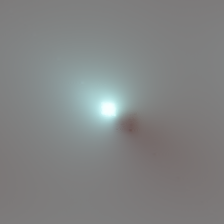

(55, 55)
(27, 27)
[(106.0, 117.0), (106.0, 117.0)]
generating feature_viz objective string for 2
deepviz image not found for 2, generating . . .
generating featviz with objective: features_0:2
------------------------------------------------------------------------------
        Layer (type)    map size      start       jump receptive_field 
        0             [224, 224]        0.5        1.0             1.0 
        1               [55, 55]        3.5        4.0            11.0 
        2               [55, 55]        3.5        4.0            11.0 
        3               [27, 27]        7.5        8.0            19.0 
        4               [27, 27]        7.5        8.0            51.0 
        5               [27, 27]        7.5        8.0            51.0 
        6               [13, 13]       15.5       16.0            67.0 
        7               [13, 13]       15.5       16.0            99.0 


100%|██████████| 512/512 [00:08<00:00, 58.79it/s]



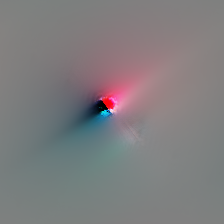

(55, 55)
(27, 27)
[(106.0, 117.0), (106.0, 117.0)]
generating feature_viz objective string for 3
deepviz image not found for 3, generating . . .
generating featviz with objective: features_0:3
------------------------------------------------------------------------------
        Layer (type)    map size      start       jump receptive_field 
        0             [224, 224]        0.5        1.0             1.0 
        1               [55, 55]        3.5        4.0            11.0 
        2               [55, 55]        3.5        4.0            11.0 
        3               [27, 27]        7.5        8.0            19.0 
        4               [27, 27]        7.5        8.0            51.0 
        5               [27, 27]        7.5        8.0            51.0 
        6               [13, 13]       15.5       16.0            67.0 
        7               [13, 13]       15.5       16.0            99.0 


100%|██████████| 512/512 [00:08<00:00, 58.33it/s]



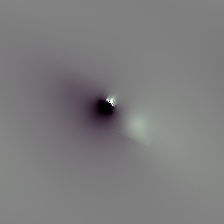

(55, 55)
(27, 27)
[(106.0, 117.0), (106.0, 117.0)]
generating feature_viz objective string for 4
deepviz image not found for 4, generating . . .
generating featviz with objective: features_0:4
------------------------------------------------------------------------------
        Layer (type)    map size      start       jump receptive_field 
        0             [224, 224]        0.5        1.0             1.0 
        1               [55, 55]        3.5        4.0            11.0 
        2               [55, 55]        3.5        4.0            11.0 
        3               [27, 27]        7.5        8.0            19.0 
        4               [27, 27]        7.5        8.0            51.0 
        5               [27, 27]        7.5        8.0            51.0 
        6               [13, 13]       15.5       16.0            67.0 
        7               [13, 13]       15.5       16.0            99.0 


100%|██████████| 512/512 [00:08<00:00, 58.34it/s]



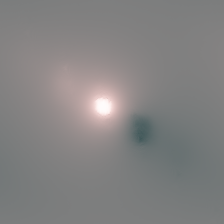

(55, 55)
(27, 27)
[(106.0, 117.0), (106.0, 117.0)]
generating feature_viz objective string for 6
deepviz image not found for 6, generating . . .
generating featviz with objective: features_0:6
------------------------------------------------------------------------------
        Layer (type)    map size      start       jump receptive_field 
        0             [224, 224]        0.5        1.0             1.0 
        1               [55, 55]        3.5        4.0            11.0 
        2               [55, 55]        3.5        4.0            11.0 
        3               [27, 27]        7.5        8.0            19.0 
        4               [27, 27]        7.5        8.0            51.0 
        5               [27, 27]        7.5        8.0            51.0 
        6               [13, 13]       15.5       16.0            67.0 
        7               [13, 13]       15.5       16.0            99.0 


100%|██████████| 512/512 [00:08<00:00, 58.48it/s]



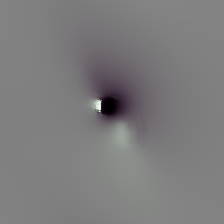

(55, 55)
(27, 27)
[(106.0, 117.0), (106.0, 117.0)]
generating feature_viz objective string for 7
deepviz image not found for 7, generating . . .
generating featviz with objective: features_0:7
------------------------------------------------------------------------------
        Layer (type)    map size      start       jump receptive_field 
        0             [224, 224]        0.5        1.0             1.0 
        1               [55, 55]        3.5        4.0            11.0 
        2               [55, 55]        3.5        4.0            11.0 
        3               [27, 27]        7.5        8.0            19.0 
        4               [27, 27]        7.5        8.0            51.0 
        5               [27, 27]        7.5        8.0            51.0 
        6               [13, 13]       15.5       16.0            67.0 
        7               [13, 13]       15.5       16.0            99.0 


100%|██████████| 512/512 [00:08<00:00, 58.62it/s]



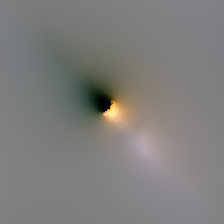

(55, 55)
(27, 27)
[(106.0, 117.0), (106.0, 117.0)]
generating feature_viz objective string for 8
deepviz image not found for 8, generating . . .
generating featviz with objective: features_0:8
------------------------------------------------------------------------------
        Layer (type)    map size      start       jump receptive_field 
        0             [224, 224]        0.5        1.0             1.0 
        1               [55, 55]        3.5        4.0            11.0 
        2               [55, 55]        3.5        4.0            11.0 
        3               [27, 27]        7.5        8.0            19.0 
        4               [27, 27]        7.5        8.0            51.0 
        5               [27, 27]        7.5        8.0            51.0 
        6               [13, 13]       15.5       16.0            67.0 
        7               [13, 13]       15.5       16.0            99.0 


100%|██████████| 512/512 [00:08<00:00, 58.27it/s]



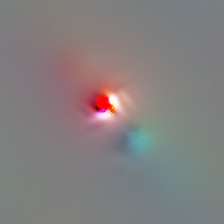

(55, 55)
(27, 27)
[(106.0, 117.0), (106.0, 117.0)]
generating feature_viz objective string for 9
deepviz image not found for 9, generating . . .
generating featviz with objective: features_0:9
------------------------------------------------------------------------------
        Layer (type)    map size      start       jump receptive_field 
        0             [224, 224]        0.5        1.0             1.0 
        1               [55, 55]        3.5        4.0            11.0 
        2               [55, 55]        3.5        4.0            11.0 
        3               [27, 27]        7.5        8.0            19.0 
        4               [27, 27]        7.5        8.0            51.0 
        5               [27, 27]        7.5        8.0            51.0 
        6               [13, 13]       15.5       16.0            67.0 
        7               [13, 13]       15.5       16.0            99.0 


100%|██████████| 512/512 [00:08<00:00, 58.10it/s]



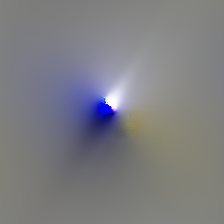

(55, 55)
(27, 27)
[(106.0, 117.0), (106.0, 117.0)]
generating feature_viz objective string for 10
deepviz image not found for 10, generating . . .
generating featviz with objective: features_0:10
------------------------------------------------------------------------------
        Layer (type)    map size      start       jump receptive_field 
        0             [224, 224]        0.5        1.0             1.0 
        1               [55, 55]        3.5        4.0            11.0 
        2               [55, 55]        3.5        4.0            11.0 
        3               [27, 27]        7.5        8.0            19.0 
        4               [27, 27]        7.5        8.0            51.0 
        5               [27, 27]        7.5        8.0            51.0 
        6               [13, 13]       15.5       16.0            67.0 
        7               [13, 13]       15.5       16.0            99.0 


100%|██████████| 512/512 [00:08<00:00, 58.11it/s]



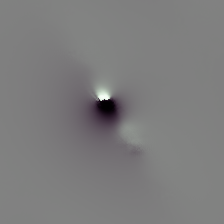

(55, 55)
(27, 27)
[(106.0, 117.0), (106.0, 117.0)]
generating feature_viz objective string for 11
deepviz image not found for 11, generating . . .
generating featviz with objective: features_0:11
------------------------------------------------------------------------------
        Layer (type)    map size      start       jump receptive_field 
        0             [224, 224]        0.5        1.0             1.0 
        1               [55, 55]        3.5        4.0            11.0 
        2               [55, 55]        3.5        4.0            11.0 
        3               [27, 27]        7.5        8.0            19.0 
        4               [27, 27]        7.5        8.0            51.0 
        5               [27, 27]        7.5        8.0            51.0 
        6               [13, 13]       15.5       16.0            67.0 
        7               [13, 13]       15.5       16.0            99.0 


100%|██████████| 512/512 [00:07<00:00, 64.76it/s]



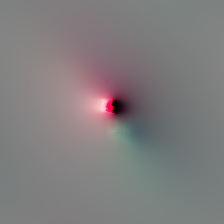

(55, 55)
(27, 27)
[(106.0, 117.0), (106.0, 117.0)]
generating feature_viz objective string for 12
deepviz image not found for 12, generating . . .
generating featviz with objective: features_0:12
------------------------------------------------------------------------------
        Layer (type)    map size      start       jump receptive_field 
        0             [224, 224]        0.5        1.0             1.0 
        1               [55, 55]        3.5        4.0            11.0 
        2               [55, 55]        3.5        4.0            11.0 
        3               [27, 27]        7.5        8.0            19.0 
        4               [27, 27]        7.5        8.0            51.0 
        5               [27, 27]        7.5        8.0            51.0 
        6               [13, 13]       15.5       16.0            67.0 
        7               [13, 13]       15.5       16.0            99.0 


100%|██████████| 512/512 [00:07<00:00, 66.39it/s]



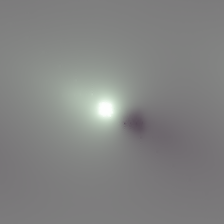

(55, 55)
(27, 27)
[(106.0, 117.0), (106.0, 117.0)]
generating feature_viz objective string for 13
deepviz image not found for 13, generating . . .
generating featviz with objective: features_0:13
------------------------------------------------------------------------------
        Layer (type)    map size      start       jump receptive_field 
        0             [224, 224]        0.5        1.0             1.0 
        1               [55, 55]        3.5        4.0            11.0 
        2               [55, 55]        3.5        4.0            11.0 
        3               [27, 27]        7.5        8.0            19.0 
        4               [27, 27]        7.5        8.0            51.0 
        5               [27, 27]        7.5        8.0            51.0 
        6               [13, 13]       15.5       16.0            67.0 
        7               [13, 13]       15.5       16.0            99.0 


100%|██████████| 512/512 [00:08<00:00, 58.52it/s]



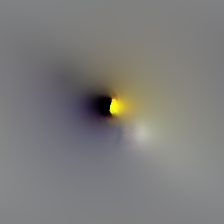

(55, 55)
(27, 27)
[(106.0, 117.0), (106.0, 117.0)]
generating feature_viz objective string for 14
deepviz image not found for 14, generating . . .
generating featviz with objective: features_0:14
------------------------------------------------------------------------------
        Layer (type)    map size      start       jump receptive_field 
        0             [224, 224]        0.5        1.0             1.0 
        1               [55, 55]        3.5        4.0            11.0 
        2               [55, 55]        3.5        4.0            11.0 
        3               [27, 27]        7.5        8.0            19.0 
        4               [27, 27]        7.5        8.0            51.0 
        5               [27, 27]        7.5        8.0            51.0 
        6               [13, 13]       15.5       16.0            67.0 
        7               [13, 13]       15.5       16.0            99.0 


100%|██████████| 512/512 [00:08<00:00, 58.18it/s]



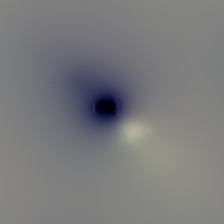

(55, 55)
(27, 27)
[(106.0, 117.0), (106.0, 117.0)]
generating feature_viz objective string for 16
deepviz image not found for 16, generating . . .
generating featviz with objective: features_0:16
------------------------------------------------------------------------------
        Layer (type)    map size      start       jump receptive_field 
        0             [224, 224]        0.5        1.0             1.0 
        1               [55, 55]        3.5        4.0            11.0 
        2               [55, 55]        3.5        4.0            11.0 
        3               [27, 27]        7.5        8.0            19.0 
        4               [27, 27]        7.5        8.0            51.0 
        5               [27, 27]        7.5        8.0            51.0 
        6               [13, 13]       15.5       16.0            67.0 
        7               [13, 13]       15.5       16.0            99.0 


100%|██████████| 512/512 [00:08<00:00, 58.43it/s]



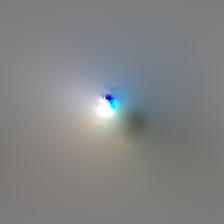

(55, 55)
(27, 27)
[(106.0, 117.0), (106.0, 117.0)]
generating feature_viz objective string for 17
deepviz image not found for 17, generating . . .
generating featviz with objective: features_0:17
------------------------------------------------------------------------------
        Layer (type)    map size      start       jump receptive_field 
        0             [224, 224]        0.5        1.0             1.0 
        1               [55, 55]        3.5        4.0            11.0 
        2               [55, 55]        3.5        4.0            11.0 
        3               [27, 27]        7.5        8.0            19.0 
        4               [27, 27]        7.5        8.0            51.0 
        5               [27, 27]        7.5        8.0            51.0 
        6               [13, 13]       15.5       16.0            67.0 
        7               [13, 13]       15.5       16.0            99.0 


100%|██████████| 512/512 [00:08<00:00, 59.47it/s]



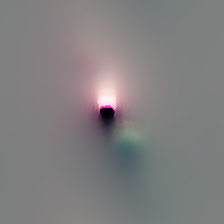

(55, 55)
(27, 27)
[(106.0, 117.0), (106.0, 117.0)]
generating feature_viz objective string for 18
deepviz image not found for 18, generating . . .
generating featviz with objective: features_0:18
------------------------------------------------------------------------------
        Layer (type)    map size      start       jump receptive_field 
        0             [224, 224]        0.5        1.0             1.0 
        1               [55, 55]        3.5        4.0            11.0 
        2               [55, 55]        3.5        4.0            11.0 
        3               [27, 27]        7.5        8.0            19.0 
        4               [27, 27]        7.5        8.0            51.0 
        5               [27, 27]        7.5        8.0            51.0 
        6               [13, 13]       15.5       16.0            67.0 
        7               [13, 13]       15.5       16.0            99.0 


100%|██████████| 512/512 [00:08<00:00, 58.32it/s]



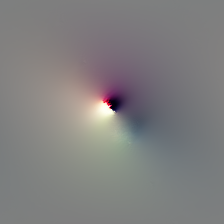

(55, 55)
(27, 27)
[(106.0, 117.0), (106.0, 117.0)]
generating feature_viz objective string for 20
deepviz image not found for 20, generating . . .
generating featviz with objective: features_0:20
------------------------------------------------------------------------------
        Layer (type)    map size      start       jump receptive_field 
        0             [224, 224]        0.5        1.0             1.0 
        1               [55, 55]        3.5        4.0            11.0 
        2               [55, 55]        3.5        4.0            11.0 
        3               [27, 27]        7.5        8.0            19.0 
        4               [27, 27]        7.5        8.0            51.0 
        5               [27, 27]        7.5        8.0            51.0 
        6               [13, 13]       15.5       16.0            67.0 
        7               [13, 13]       15.5       16.0            99.0 


100%|██████████| 512/512 [00:08<00:00, 58.50it/s]



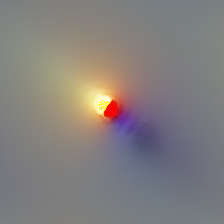

(55, 55)
(27, 27)
[(106.0, 117.0), (106.0, 117.0)]
generating feature_viz objective string for 21
deepviz image not found for 21, generating . . .
generating featviz with objective: features_0:21
------------------------------------------------------------------------------
        Layer (type)    map size      start       jump receptive_field 
        0             [224, 224]        0.5        1.0             1.0 
        1               [55, 55]        3.5        4.0            11.0 
        2               [55, 55]        3.5        4.0            11.0 
        3               [27, 27]        7.5        8.0            19.0 
        4               [27, 27]        7.5        8.0            51.0 
        5               [27, 27]        7.5        8.0            51.0 
        6               [13, 13]       15.5       16.0            67.0 
        7               [13, 13]       15.5       16.0            99.0 


100%|██████████| 512/512 [00:08<00:00, 58.24it/s]



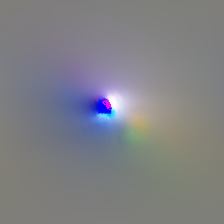

(55, 55)
(27, 27)
[(106.0, 117.0), (106.0, 117.0)]
generating feature_viz objective string for 22
deepviz image not found for 22, generating . . .
generating featviz with objective: features_0:22
------------------------------------------------------------------------------
        Layer (type)    map size      start       jump receptive_field 
        0             [224, 224]        0.5        1.0             1.0 
        1               [55, 55]        3.5        4.0            11.0 
        2               [55, 55]        3.5        4.0            11.0 
        3               [27, 27]        7.5        8.0            19.0 
        4               [27, 27]        7.5        8.0            51.0 
        5               [27, 27]        7.5        8.0            51.0 
        6               [13, 13]       15.5       16.0            67.0 
        7               [13, 13]       15.5       16.0            99.0 


100%|██████████| 512/512 [00:08<00:00, 58.31it/s]



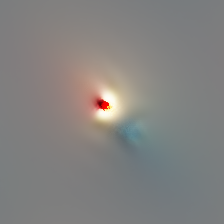

(55, 55)
(27, 27)
[(106.0, 117.0), (106.0, 117.0)]
generating feature_viz objective string for 25
deepviz image not found for 25, generating . . .
generating featviz with objective: features_0:25
------------------------------------------------------------------------------
        Layer (type)    map size      start       jump receptive_field 
        0             [224, 224]        0.5        1.0             1.0 
        1               [55, 55]        3.5        4.0            11.0 
        2               [55, 55]        3.5        4.0            11.0 
        3               [27, 27]        7.5        8.0            19.0 
        4               [27, 27]        7.5        8.0            51.0 
        5               [27, 27]        7.5        8.0            51.0 
        6               [13, 13]       15.5       16.0            67.0 
        7               [13, 13]       15.5       16.0            99.0 


100%|██████████| 512/512 [00:08<00:00, 58.10it/s]



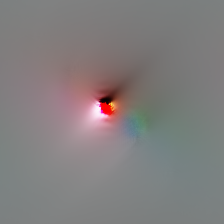

(55, 55)
(27, 27)
[(106.0, 117.0), (106.0, 117.0)]
generating feature_viz objective string for 26
deepviz image not found for 26, generating . . .
generating featviz with objective: features_0:26
------------------------------------------------------------------------------
        Layer (type)    map size      start       jump receptive_field 
        0             [224, 224]        0.5        1.0             1.0 
        1               [55, 55]        3.5        4.0            11.0 
        2               [55, 55]        3.5        4.0            11.0 
        3               [27, 27]        7.5        8.0            19.0 
        4               [27, 27]        7.5        8.0            51.0 
        5               [27, 27]        7.5        8.0            51.0 
        6               [13, 13]       15.5       16.0            67.0 
        7               [13, 13]       15.5       16.0            99.0 


100%|██████████| 512/512 [00:08<00:00, 58.96it/s]



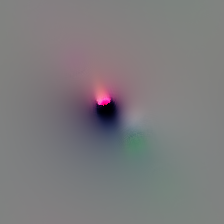

(55, 55)
(27, 27)
[(106.0, 117.0), (106.0, 117.0)]
generating feature_viz objective string for 27
deepviz image not found for 27, generating . . .
generating featviz with objective: features_0:27
------------------------------------------------------------------------------
        Layer (type)    map size      start       jump receptive_field 
        0             [224, 224]        0.5        1.0             1.0 
        1               [55, 55]        3.5        4.0            11.0 
        2               [55, 55]        3.5        4.0            11.0 
        3               [27, 27]        7.5        8.0            19.0 
        4               [27, 27]        7.5        8.0            51.0 
        5               [27, 27]        7.5        8.0            51.0 
        6               [13, 13]       15.5       16.0            67.0 
        7               [13, 13]       15.5       16.0            99.0 


100%|██████████| 512/512 [00:08<00:00, 57.88it/s]



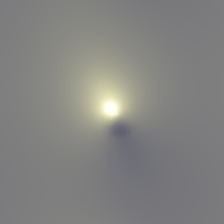

(55, 55)
(27, 27)
[(106.0, 117.0), (106.0, 117.0)]
generating feature_viz objective string for 28
deepviz image not found for 28, generating . . .
generating featviz with objective: features_0:28
------------------------------------------------------------------------------
        Layer (type)    map size      start       jump receptive_field 
        0             [224, 224]        0.5        1.0             1.0 
        1               [55, 55]        3.5        4.0            11.0 
        2               [55, 55]        3.5        4.0            11.0 
        3               [27, 27]        7.5        8.0            19.0 
        4               [27, 27]        7.5        8.0            51.0 
        5               [27, 27]        7.5        8.0            51.0 
        6               [13, 13]       15.5       16.0            67.0 
        7               [13, 13]       15.5       16.0            99.0 


100%|██████████| 512/512 [00:08<00:00, 58.08it/s]



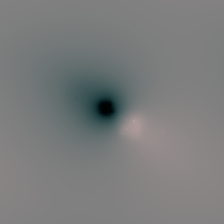

(55, 55)
(27, 27)
[(106.0, 117.0), (106.0, 117.0)]
generating feature_viz objective string for 30
deepviz image not found for 30, generating . . .
generating featviz with objective: features_0:30
------------------------------------------------------------------------------
        Layer (type)    map size      start       jump receptive_field 
        0             [224, 224]        0.5        1.0             1.0 
        1               [55, 55]        3.5        4.0            11.0 
        2               [55, 55]        3.5        4.0            11.0 
        3               [27, 27]        7.5        8.0            19.0 
        4               [27, 27]        7.5        8.0            51.0 
        5               [27, 27]        7.5        8.0            51.0 
        6               [13, 13]       15.5       16.0            67.0 
        7               [13, 13]       15.5       16.0            99.0 


100%|██████████| 512/512 [00:08<00:00, 58.32it/s]



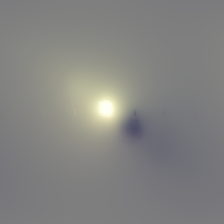

(55, 55)
(27, 27)
[(106.0, 117.0), (106.0, 117.0)]
generating feature_viz objective string for 31
deepviz image not found for 31, generating . . .
generating featviz with objective: features_0:31
------------------------------------------------------------------------------
        Layer (type)    map size      start       jump receptive_field 
        0             [224, 224]        0.5        1.0             1.0 
        1               [55, 55]        3.5        4.0            11.0 
        2               [55, 55]        3.5        4.0            11.0 
        3               [27, 27]        7.5        8.0            19.0 
        4               [27, 27]        7.5        8.0            51.0 
        5               [27, 27]        7.5        8.0            51.0 
        6               [13, 13]       15.5       16.0            67.0 
        7               [13, 13]       15.5       16.0            99.0 


100%|██████████| 512/512 [00:08<00:00, 58.20it/s]



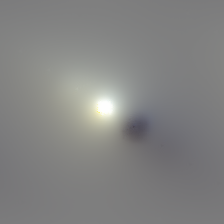

(55, 55)
(27, 27)
[(106.0, 117.0), (106.0, 117.0)]
generating feature_viz objective string for 32
deepviz image not found for 32, generating . . .
generating featviz with objective: features_0:32
------------------------------------------------------------------------------
        Layer (type)    map size      start       jump receptive_field 
        0             [224, 224]        0.5        1.0             1.0 
        1               [55, 55]        3.5        4.0            11.0 
        2               [55, 55]        3.5        4.0            11.0 
        3               [27, 27]        7.5        8.0            19.0 
        4               [27, 27]        7.5        8.0            51.0 
        5               [27, 27]        7.5        8.0            51.0 
        6               [13, 13]       15.5       16.0            67.0 
        7               [13, 13]       15.5       16.0            99.0 


100%|██████████| 512/512 [00:08<00:00, 57.77it/s]



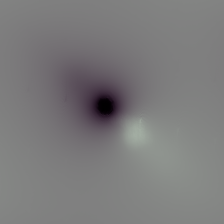

(55, 55)
(27, 27)
[(106.0, 117.0), (106.0, 117.0)]
generating feature_viz objective string for 33
deepviz image not found for 33, generating . . .
generating featviz with objective: features_0:33
------------------------------------------------------------------------------
        Layer (type)    map size      start       jump receptive_field 
        0             [224, 224]        0.5        1.0             1.0 
        1               [55, 55]        3.5        4.0            11.0 
        2               [55, 55]        3.5        4.0            11.0 
        3               [27, 27]        7.5        8.0            19.0 
        4               [27, 27]        7.5        8.0            51.0 
        5               [27, 27]        7.5        8.0            51.0 
        6               [13, 13]       15.5       16.0            67.0 
        7               [13, 13]       15.5       16.0            99.0 


100%|██████████| 512/512 [00:08<00:00, 57.83it/s]



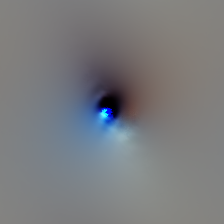

(55, 55)
(27, 27)
[(106.0, 117.0), (106.0, 117.0)]
generating feature_viz objective string for 34
deepviz image not found for 34, generating . . .
generating featviz with objective: features_0:34
------------------------------------------------------------------------------
        Layer (type)    map size      start       jump receptive_field 
        0             [224, 224]        0.5        1.0             1.0 
        1               [55, 55]        3.5        4.0            11.0 
        2               [55, 55]        3.5        4.0            11.0 
        3               [27, 27]        7.5        8.0            19.0 
        4               [27, 27]        7.5        8.0            51.0 
        5               [27, 27]        7.5        8.0            51.0 
        6               [13, 13]       15.5       16.0            67.0 
        7               [13, 13]       15.5       16.0            99.0 


100%|██████████| 512/512 [00:08<00:00, 57.78it/s]



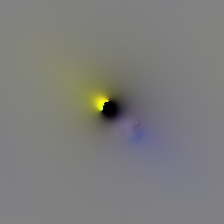

(55, 55)
(27, 27)
[(106.0, 117.0), (106.0, 117.0)]
generating feature_viz objective string for 37
deepviz image not found for 37, generating . . .
generating featviz with objective: features_0:37
------------------------------------------------------------------------------
        Layer (type)    map size      start       jump receptive_field 
        0             [224, 224]        0.5        1.0             1.0 
        1               [55, 55]        3.5        4.0            11.0 
        2               [55, 55]        3.5        4.0            11.0 
        3               [27, 27]        7.5        8.0            19.0 
        4               [27, 27]        7.5        8.0            51.0 
        5               [27, 27]        7.5        8.0            51.0 
        6               [13, 13]       15.5       16.0            67.0 
        7               [13, 13]       15.5       16.0            99.0 


100%|██████████| 512/512 [00:08<00:00, 57.91it/s]



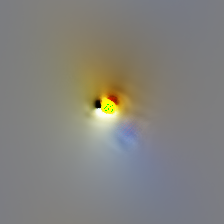

(55, 55)
(27, 27)
[(106.0, 117.0), (106.0, 117.0)]
generating feature_viz objective string for 39
deepviz image not found for 39, generating . . .
generating featviz with objective: features_0:39
------------------------------------------------------------------------------
        Layer (type)    map size      start       jump receptive_field 
        0             [224, 224]        0.5        1.0             1.0 
        1               [55, 55]        3.5        4.0            11.0 
        2               [55, 55]        3.5        4.0            11.0 
        3               [27, 27]        7.5        8.0            19.0 
        4               [27, 27]        7.5        8.0            51.0 
        5               [27, 27]        7.5        8.0            51.0 
        6               [13, 13]       15.5       16.0            67.0 
        7               [13, 13]       15.5       16.0            99.0 


100%|██████████| 512/512 [00:08<00:00, 57.98it/s]



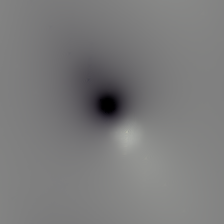

(55, 55)
(27, 27)
[(106.0, 117.0), (106.0, 117.0)]
generating feature_viz objective string for 40
deepviz image not found for 40, generating . . .
generating featviz with objective: features_0:40
------------------------------------------------------------------------------
        Layer (type)    map size      start       jump receptive_field 
        0             [224, 224]        0.5        1.0             1.0 
        1               [55, 55]        3.5        4.0            11.0 
        2               [55, 55]        3.5        4.0            11.0 
        3               [27, 27]        7.5        8.0            19.0 
        4               [27, 27]        7.5        8.0            51.0 
        5               [27, 27]        7.5        8.0            51.0 
        6               [13, 13]       15.5       16.0            67.0 
        7               [13, 13]       15.5       16.0            99.0 


100%|██████████| 512/512 [00:08<00:00, 57.61it/s]



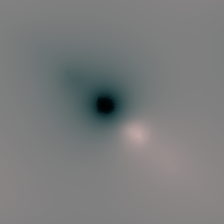

(55, 55)
(27, 27)
[(106.0, 117.0), (106.0, 117.0)]
generating feature_viz objective string for 41
deepviz image not found for 41, generating . . .
generating featviz with objective: features_0:41
------------------------------------------------------------------------------
        Layer (type)    map size      start       jump receptive_field 
        0             [224, 224]        0.5        1.0             1.0 
        1               [55, 55]        3.5        4.0            11.0 
        2               [55, 55]        3.5        4.0            11.0 
        3               [27, 27]        7.5        8.0            19.0 
        4               [27, 27]        7.5        8.0            51.0 
        5               [27, 27]        7.5        8.0            51.0 
        6               [13, 13]       15.5       16.0            67.0 
        7               [13, 13]       15.5       16.0            99.0 


100%|██████████| 512/512 [00:08<00:00, 57.93it/s]



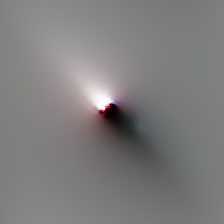

(55, 55)
(27, 27)
[(106.0, 117.0), (106.0, 117.0)]
generating feature_viz objective string for 42
deepviz image not found for 42, generating . . .
generating featviz with objective: features_0:42
------------------------------------------------------------------------------
        Layer (type)    map size      start       jump receptive_field 
        0             [224, 224]        0.5        1.0             1.0 
        1               [55, 55]        3.5        4.0            11.0 
        2               [55, 55]        3.5        4.0            11.0 
        3               [27, 27]        7.5        8.0            19.0 
        4               [27, 27]        7.5        8.0            51.0 
        5               [27, 27]        7.5        8.0            51.0 
        6               [13, 13]       15.5       16.0            67.0 
        7               [13, 13]       15.5       16.0            99.0 


100%|██████████| 512/512 [00:07<00:00, 64.73it/s]



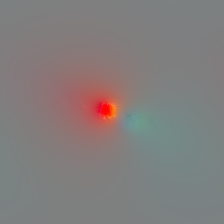

(55, 55)
(27, 27)
[(106.0, 117.0), (106.0, 117.0)]
generating feature_viz objective string for 43
deepviz image not found for 43, generating . . .
generating featviz with objective: features_0:43
------------------------------------------------------------------------------
        Layer (type)    map size      start       jump receptive_field 
        0             [224, 224]        0.5        1.0             1.0 
        1               [55, 55]        3.5        4.0            11.0 
        2               [55, 55]        3.5        4.0            11.0 
        3               [27, 27]        7.5        8.0            19.0 
        4               [27, 27]        7.5        8.0            51.0 
        5               [27, 27]        7.5        8.0            51.0 
        6               [13, 13]       15.5       16.0            67.0 
        7               [13, 13]       15.5       16.0            99.0 


100%|██████████| 512/512 [00:07<00:00, 65.01it/s]



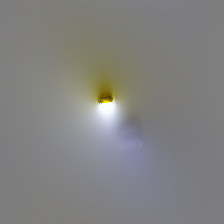

(55, 55)
(27, 27)
[(106.0, 117.0), (106.0, 117.0)]
generating feature_viz objective string for 44
deepviz image not found for 44, generating . . .
generating featviz with objective: features_0:44
------------------------------------------------------------------------------
        Layer (type)    map size      start       jump receptive_field 
        0             [224, 224]        0.5        1.0             1.0 
        1               [55, 55]        3.5        4.0            11.0 
        2               [55, 55]        3.5        4.0            11.0 
        3               [27, 27]        7.5        8.0            19.0 
        4               [27, 27]        7.5        8.0            51.0 
        5               [27, 27]        7.5        8.0            51.0 
        6               [13, 13]       15.5       16.0            67.0 
        7               [13, 13]       15.5       16.0            99.0 


100%|██████████| 512/512 [00:08<00:00, 57.87it/s]



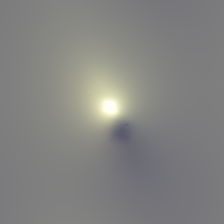

(55, 55)
(27, 27)
[(106.0, 117.0), (106.0, 117.0)]
generating feature_viz objective string for 45
deepviz image not found for 45, generating . . .
generating featviz with objective: features_0:45
------------------------------------------------------------------------------
        Layer (type)    map size      start       jump receptive_field 
        0             [224, 224]        0.5        1.0             1.0 
        1               [55, 55]        3.5        4.0            11.0 
        2               [55, 55]        3.5        4.0            11.0 
        3               [27, 27]        7.5        8.0            19.0 
        4               [27, 27]        7.5        8.0            51.0 
        5               [27, 27]        7.5        8.0            51.0 
        6               [13, 13]       15.5       16.0            67.0 
        7               [13, 13]       15.5       16.0            99.0 


100%|██████████| 512/512 [00:08<00:00, 57.57it/s]



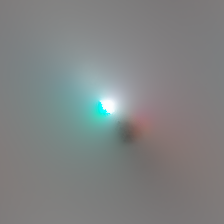

(55, 55)
(27, 27)
[(106.0, 117.0), (106.0, 117.0)]
generating feature_viz objective string for 46
deepviz image not found for 46, generating . . .
generating featviz with objective: features_0:46
------------------------------------------------------------------------------
        Layer (type)    map size      start       jump receptive_field 
        0             [224, 224]        0.5        1.0             1.0 
        1               [55, 55]        3.5        4.0            11.0 
        2               [55, 55]        3.5        4.0            11.0 
        3               [27, 27]        7.5        8.0            19.0 
        4               [27, 27]        7.5        8.0            51.0 
        5               [27, 27]        7.5        8.0            51.0 
        6               [13, 13]       15.5       16.0            67.0 
        7               [13, 13]       15.5       16.0            99.0 


100%|██████████| 512/512 [00:08<00:00, 57.44it/s]



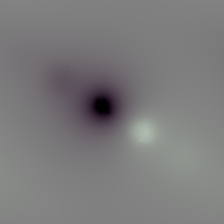

(55, 55)
(27, 27)
[(106.0, 117.0), (106.0, 117.0)]
generating feature_viz objective string for 47
deepviz image not found for 47, generating . . .
generating featviz with objective: features_0:47
------------------------------------------------------------------------------
        Layer (type)    map size      start       jump receptive_field 
        0             [224, 224]        0.5        1.0             1.0 
        1               [55, 55]        3.5        4.0            11.0 
        2               [55, 55]        3.5        4.0            11.0 
        3               [27, 27]        7.5        8.0            19.0 
        4               [27, 27]        7.5        8.0            51.0 
        5               [27, 27]        7.5        8.0            51.0 
        6               [13, 13]       15.5       16.0            67.0 
        7               [13, 13]       15.5       16.0            99.0 


100%|██████████| 512/512 [00:08<00:00, 62.16it/s]



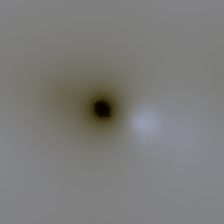

(55, 55)
(27, 27)
[(106.0, 117.0), (106.0, 117.0)]
generating feature_viz objective string for 48
deepviz image not found for 48, generating . . .
generating featviz with objective: features_0:48
------------------------------------------------------------------------------
        Layer (type)    map size      start       jump receptive_field 
        0             [224, 224]        0.5        1.0             1.0 
        1               [55, 55]        3.5        4.0            11.0 
        2               [55, 55]        3.5        4.0            11.0 
        3               [27, 27]        7.5        8.0            19.0 
        4               [27, 27]        7.5        8.0            51.0 
        5               [27, 27]        7.5        8.0            51.0 
        6               [13, 13]       15.5       16.0            67.0 
        7               [13, 13]       15.5       16.0            99.0 


100%|██████████| 512/512 [00:08<00:00, 58.60it/s]



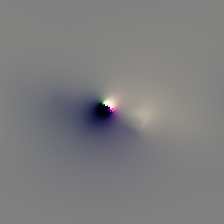

(55, 55)
(27, 27)
[(106.0, 117.0), (106.0, 117.0)]
generating feature_viz objective string for 49
deepviz image not found for 49, generating . . .
generating featviz with objective: features_0:49
------------------------------------------------------------------------------
        Layer (type)    map size      start       jump receptive_field 
        0             [224, 224]        0.5        1.0             1.0 
        1               [55, 55]        3.5        4.0            11.0 
        2               [55, 55]        3.5        4.0            11.0 
        3               [27, 27]        7.5        8.0            19.0 
        4               [27, 27]        7.5        8.0            51.0 
        5               [27, 27]        7.5        8.0            51.0 
        6               [13, 13]       15.5       16.0            67.0 
        7               [13, 13]       15.5       16.0            99.0 


100%|██████████| 512/512 [00:07<00:00, 64.37it/s]



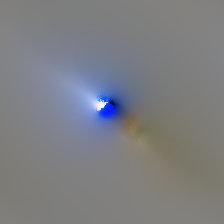

(55, 55)
(27, 27)
[(106.0, 117.0), (106.0, 117.0)]
generating feature_viz objective string for 50
deepviz image not found for 50, generating . . .
generating featviz with objective: features_0:50
------------------------------------------------------------------------------
        Layer (type)    map size      start       jump receptive_field 
        0             [224, 224]        0.5        1.0             1.0 
        1               [55, 55]        3.5        4.0            11.0 
        2               [55, 55]        3.5        4.0            11.0 
        3               [27, 27]        7.5        8.0            19.0 
        4               [27, 27]        7.5        8.0            51.0 
        5               [27, 27]        7.5        8.0            51.0 
        6               [13, 13]       15.5       16.0            67.0 
        7               [13, 13]       15.5       16.0            99.0 


100%|██████████| 512/512 [00:07<00:00, 64.94it/s]



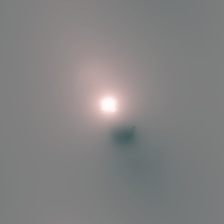

(55, 55)
(27, 27)
[(106.0, 117.0), (106.0, 117.0)]
generating feature_viz objective string for 52
deepviz image not found for 52, generating . . .
generating featviz with objective: features_0:52
------------------------------------------------------------------------------
        Layer (type)    map size      start       jump receptive_field 
        0             [224, 224]        0.5        1.0             1.0 
        1               [55, 55]        3.5        4.0            11.0 
        2               [55, 55]        3.5        4.0            11.0 
        3               [27, 27]        7.5        8.0            19.0 
        4               [27, 27]        7.5        8.0            51.0 
        5               [27, 27]        7.5        8.0            51.0 
        6               [13, 13]       15.5       16.0            67.0 
        7               [13, 13]       15.5       16.0            99.0 


100%|██████████| 512/512 [00:07<00:00, 65.23it/s]



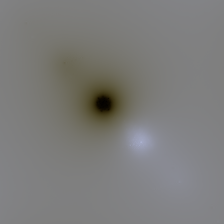

(55, 55)
(27, 27)
[(106.0, 117.0), (106.0, 117.0)]
generating feature_viz objective string for 54
deepviz image not found for 54, generating . . .
generating featviz with objective: features_0:54
------------------------------------------------------------------------------
        Layer (type)    map size      start       jump receptive_field 
        0             [224, 224]        0.5        1.0             1.0 
        1               [55, 55]        3.5        4.0            11.0 
        2               [55, 55]        3.5        4.0            11.0 
        3               [27, 27]        7.5        8.0            19.0 
        4               [27, 27]        7.5        8.0            51.0 
        5               [27, 27]        7.5        8.0            51.0 
        6               [13, 13]       15.5       16.0            67.0 
        7               [13, 13]       15.5       16.0            99.0 


100%|██████████| 512/512 [00:08<00:00, 58.55it/s]



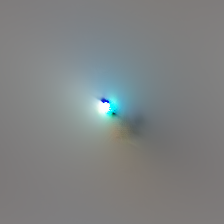

(55, 55)
(27, 27)
[(106.0, 117.0), (106.0, 117.0)]
generating feature_viz objective string for 55
deepviz image not found for 55, generating . . .
generating featviz with objective: features_0:55
------------------------------------------------------------------------------
        Layer (type)    map size      start       jump receptive_field 
        0             [224, 224]        0.5        1.0             1.0 
        1               [55, 55]        3.5        4.0            11.0 
        2               [55, 55]        3.5        4.0            11.0 
        3               [27, 27]        7.5        8.0            19.0 
        4               [27, 27]        7.5        8.0            51.0 
        5               [27, 27]        7.5        8.0            51.0 
        6               [13, 13]       15.5       16.0            67.0 
        7               [13, 13]       15.5       16.0            99.0 


100%|██████████| 512/512 [00:08<00:00, 57.48it/s]



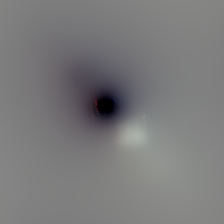

(55, 55)
(27, 27)
[(106.0, 117.0), (106.0, 117.0)]
generating feature_viz objective string for 56
deepviz image not found for 56, generating . . .
generating featviz with objective: features_0:56
------------------------------------------------------------------------------
        Layer (type)    map size      start       jump receptive_field 
        0             [224, 224]        0.5        1.0             1.0 
        1               [55, 55]        3.5        4.0            11.0 
        2               [55, 55]        3.5        4.0            11.0 
        3               [27, 27]        7.5        8.0            19.0 
        4               [27, 27]        7.5        8.0            51.0 
        5               [27, 27]        7.5        8.0            51.0 
        6               [13, 13]       15.5       16.0            67.0 
        7               [13, 13]       15.5       16.0            99.0 


100%|██████████| 512/512 [00:08<00:00, 57.36it/s]



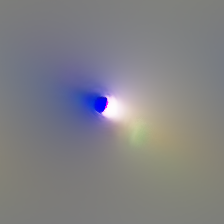

(55, 55)
(27, 27)
[(106.0, 117.0), (106.0, 117.0)]
generating feature_viz objective string for 57
deepviz image not found for 57, generating . . .
generating featviz with objective: features_0:57
------------------------------------------------------------------------------
        Layer (type)    map size      start       jump receptive_field 
        0             [224, 224]        0.5        1.0             1.0 
        1               [55, 55]        3.5        4.0            11.0 
        2               [55, 55]        3.5        4.0            11.0 
        3               [27, 27]        7.5        8.0            19.0 
        4               [27, 27]        7.5        8.0            51.0 
        5               [27, 27]        7.5        8.0            51.0 
        6               [13, 13]       15.5       16.0            67.0 
        7               [13, 13]       15.5       16.0            99.0 


100%|██████████| 512/512 [00:08<00:00, 57.49it/s]



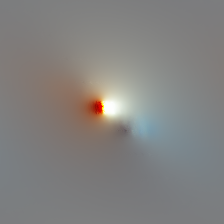

(55, 55)
(27, 27)
[(106.0, 117.0), (106.0, 117.0)]
generating feature_viz objective string for 58
deepviz image not found for 58, generating . . .
generating featviz with objective: features_0:58
------------------------------------------------------------------------------
        Layer (type)    map size      start       jump receptive_field 
        0             [224, 224]        0.5        1.0             1.0 
        1               [55, 55]        3.5        4.0            11.0 
        2               [55, 55]        3.5        4.0            11.0 
        3               [27, 27]        7.5        8.0            19.0 
        4               [27, 27]        7.5        8.0            51.0 
        5               [27, 27]        7.5        8.0            51.0 
        6               [13, 13]       15.5       16.0            67.0 
        7               [13, 13]       15.5       16.0            99.0 


100%|██████████| 512/512 [00:08<00:00, 57.59it/s]



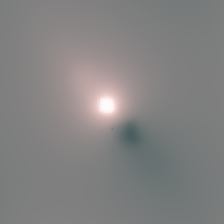

(55, 55)
(27, 27)
[(106.0, 117.0), (106.0, 117.0)]
generating feature_viz objective string for 59
deepviz image not found for 59, generating . . .
generating featviz with objective: features_0:59
------------------------------------------------------------------------------
        Layer (type)    map size      start       jump receptive_field 
        0             [224, 224]        0.5        1.0             1.0 
        1               [55, 55]        3.5        4.0            11.0 
        2               [55, 55]        3.5        4.0            11.0 
        3               [27, 27]        7.5        8.0            19.0 
        4               [27, 27]        7.5        8.0            51.0 
        5               [27, 27]        7.5        8.0            51.0 
        6               [13, 13]       15.5       16.0            67.0 
        7               [13, 13]       15.5       16.0            99.0 


100%|██████████| 512/512 [00:09<00:00, 55.54it/s]



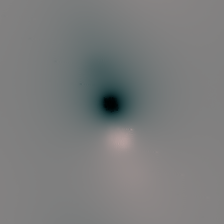

(55, 55)
(27, 27)
[(106.0, 117.0), (106.0, 117.0)]
generating feature_viz objective string for 60
deepviz image not found for 60, generating . . .
generating featviz with objective: features_0:60
------------------------------------------------------------------------------
        Layer (type)    map size      start       jump receptive_field 
        0             [224, 224]        0.5        1.0             1.0 
        1               [55, 55]        3.5        4.0            11.0 
        2               [55, 55]        3.5        4.0            11.0 
        3               [27, 27]        7.5        8.0            19.0 
        4               [27, 27]        7.5        8.0            51.0 
        5               [27, 27]        7.5        8.0            51.0 
        6               [13, 13]       15.5       16.0            67.0 
        7               [13, 13]       15.5       16.0            99.0 


100%|██████████| 512/512 [00:09<00:00, 55.39it/s]



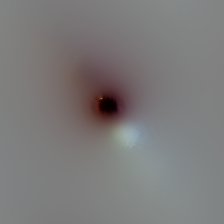

(55, 55)
(27, 27)
[(106.0, 117.0), (106.0, 117.0)]
generating feature_viz objective string for 61
deepviz image not found for 61, generating . . .
generating featviz with objective: features_0:61
------------------------------------------------------------------------------
        Layer (type)    map size      start       jump receptive_field 
        0             [224, 224]        0.5        1.0             1.0 
        1               [55, 55]        3.5        4.0            11.0 
        2               [55, 55]        3.5        4.0            11.0 
        3               [27, 27]        7.5        8.0            19.0 
        4               [27, 27]        7.5        8.0            51.0 
        5               [27, 27]        7.5        8.0            51.0 
        6               [13, 13]       15.5       16.0            67.0 
        7               [13, 13]       15.5       16.0            99.0 


100%|██████████| 512/512 [00:09<00:00, 56.38it/s]



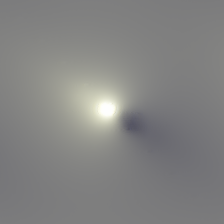

(55, 55)
(27, 27)
[(106.0, 117.0), (106.0, 117.0)]
generating feature_viz objective string for 62
deepviz image not found for 62, generating . . .
generating featviz with objective: features_0:62
------------------------------------------------------------------------------
        Layer (type)    map size      start       jump receptive_field 
        0             [224, 224]        0.5        1.0             1.0 
        1               [55, 55]        3.5        4.0            11.0 
        2               [55, 55]        3.5        4.0            11.0 
        3               [27, 27]        7.5        8.0            19.0 
        4               [27, 27]        7.5        8.0            51.0 
        5               [27, 27]        7.5        8.0            51.0 
        6               [13, 13]       15.5       16.0            67.0 
        7               [13, 13]       15.5       16.0            99.0 


 34%|███▎      | 172/512 [00:02<00:05, 57.89it/s]

Interrupted optimization at step 173.



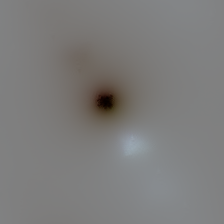

(55, 55)
(27, 27)
[(106.0, 117.0), (106.0, 117.0)]
generating feature_viz objective string for 63
deepviz image not found for 63, generating . . .
generating featviz with objective: features_0:63
------------------------------------------------------------------------------
        Layer (type)    map size      start       jump receptive_field 
        0             [224, 224]        0.5        1.0             1.0 
        1               [55, 55]        3.5        4.0            11.0 
        2               [55, 55]        3.5        4.0            11.0 
        3               [27, 27]        7.5        8.0            19.0 
        4               [27, 27]        7.5        8.0            51.0 
        5               [27, 27]        7.5        8.0            51.0 
        6               [13, 13]       15.5       16.0            67.0 
        7               [13, 13]       15.5       16.0            99.0 


  1%|          | 4/512 [00:00<00:11, 46.12it/s]


Interrupted optimization at step 5.



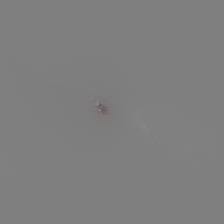

(55, 55)
(27, 27)
[(106.0, 117.0), (106.0, 117.0)]
generating feature_viz objective string for 64
deepviz image not found for 64, generating . . .
generating featviz with objective: features_3:64
------------------------------------------------------------------------------
        Layer (type)    map size      start       jump receptive_field 
        0             [224, 224]        0.5        1.0             1.0 
        1               [55, 55]        3.5        4.0            11.0 
        2               [55, 55]        3.5        4.0            11.0 
        3               [27, 27]        7.5        8.0            19.0 
        4               [27, 27]        7.5        8.0            51.0 
        5               [27, 27]        7.5        8.0            51.0 
        6               [13, 13]       15.5       16.0            67.0 
        7               [13, 13]       15.5       16.0            99.0 


  1%|          | 3/512 [00:00<00:11, 42.56it/s]

Interrupted optimization at step 4.



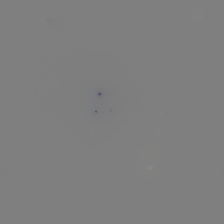

(27, 27)
(13, 13)
[(86.0, 137.0), (86.0, 137.0)]
generating feature_viz objective string for 65
deepviz image not found for 65, generating . . .
generating featviz with objective: features_3:65
------------------------------------------------------------------------------
        Layer (type)    map size      start       jump receptive_field 
        0             [224, 224]        0.5        1.0             1.0 
        1               [55, 55]        3.5        4.0            11.0 
        2               [55, 55]        3.5        4.0            11.0 
        3               [27, 27]        7.5        8.0            19.0 
        4               [27, 27]        7.5        8.0            51.0 
        5               [27, 27]        7.5        8.0            51.0 
        6               [13, 13]       15.5       16.0            67.0 
        7               [13, 13]       15.5       16.0            99.0 


  1%|          | 3/512 [00:00<00:11, 45.05it/s]

Interrupted optimization at step 4.



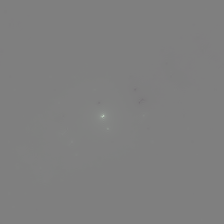

(27, 27)
(13, 13)
[(86.0, 137.0), (86.0, 137.0)]
generating feature_viz objective string for 67
deepviz image not found for 67, generating . . .
generating featviz with objective: features_3:67
------------------------------------------------------------------------------
        Layer (type)    map size      start       jump receptive_field 
        0             [224, 224]        0.5        1.0             1.0 
        1               [55, 55]        3.5        4.0            11.0 
        2               [55, 55]        3.5        4.0            11.0 
        3               [27, 27]        7.5        8.0            19.0 
        4               [27, 27]        7.5        8.0            51.0 
        5               [27, 27]        7.5        8.0            51.0 
        6               [13, 13]       15.5       16.0            67.0 
        7               [13, 13]       15.5       16.0            99.0 


  0%|          | 2/512 [00:00<00:10, 46.59it/s]

Interrupted optimization at step 3.



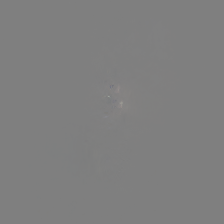

(27, 27)
(13, 13)
[(86.0, 137.0), (86.0, 137.0)]
generating feature_viz objective string for 70
deepviz image not found for 70, generating . . .
generating featviz with objective: features_3:70
------------------------------------------------------------------------------
        Layer (type)    map size      start       jump receptive_field 
        0             [224, 224]        0.5        1.0             1.0 
        1               [55, 55]        3.5        4.0            11.0 
        2               [55, 55]        3.5        4.0            11.0 
        3               [27, 27]        7.5        8.0            19.0 
        4               [27, 27]        7.5        8.0            51.0 
        5               [27, 27]        7.5        8.0            51.0 
        6               [13, 13]       15.5       16.0            67.0 
        7               [13, 13]       15.5       16.0            99.0 


  1%|          | 3/512 [00:00<00:10, 46.69it/s]

Interrupted optimization at step 4.



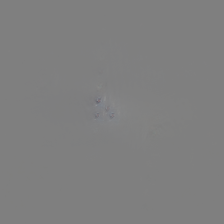

(27, 27)
(13, 13)
[(86.0, 137.0), (86.0, 137.0)]
generating feature_viz objective string for 72
deepviz image not found for 72, generating . . .
generating featviz with objective: features_3:72
------------------------------------------------------------------------------
        Layer (type)    map size      start       jump receptive_field 
        0             [224, 224]        0.5        1.0             1.0 
        1               [55, 55]        3.5        4.0            11.0 
        2               [55, 55]        3.5        4.0            11.0 
        3               [27, 27]        7.5        8.0            19.0 
        4               [27, 27]        7.5        8.0            51.0 
        5               [27, 27]        7.5        8.0            51.0 
        6               [13, 13]       15.5       16.0            67.0 
        7               [13, 13]       15.5       16.0            99.0 


  1%|          | 3/512 [00:00<00:11, 42.98it/s]

Interrupted optimization at step 4.



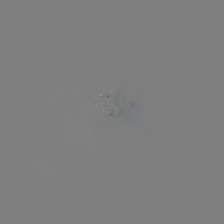

(27, 27)
(13, 13)
[(86.0, 137.0), (86.0, 137.0)]
generating feature_viz objective string for 75
deepviz image not found for 75, generating . . .
generating featviz with objective: features_3:75
------------------------------------------------------------------------------
        Layer (type)    map size      start       jump receptive_field 
        0             [224, 224]        0.5        1.0             1.0 
        1               [55, 55]        3.5        4.0            11.0 
        2               [55, 55]        3.5        4.0            11.0 
        3               [27, 27]        7.5        8.0            19.0 
        4               [27, 27]        7.5        8.0            51.0 
        5               [27, 27]        7.5        8.0            51.0 
        6               [13, 13]       15.5       16.0            67.0 
        7               [13, 13]       15.5       16.0            99.0 


 37%|███▋      | 187/512 [00:03<00:06, 50.07it/s]

Interrupted optimization at step 188.



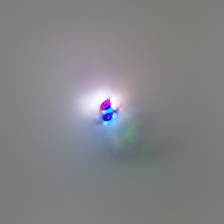

(27, 27)
(13, 13)
[(86.0, 137.0), (86.0, 137.0)]
generating feature_viz objective string for 76
deepviz image not found for 76, generating . . .
generating featviz with objective: features_3:76
------------------------------------------------------------------------------
        Layer (type)    map size      start       jump receptive_field 
        0             [224, 224]        0.5        1.0             1.0 
        1               [55, 55]        3.5        4.0            11.0 
        2               [55, 55]        3.5        4.0            11.0 
        3               [27, 27]        7.5        8.0            19.0 
        4               [27, 27]        7.5        8.0            51.0 
        5               [27, 27]        7.5        8.0            51.0 
        6               [13, 13]       15.5       16.0            67.0 
        7               [13, 13]       15.5       16.0            99.0 


  1%|          | 5/512 [00:00<00:11, 43.14it/s]

Interrupted optimization at step 6.



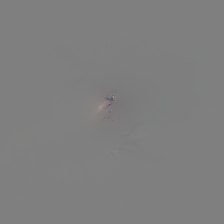

(27, 27)
(13, 13)
[(86.0, 137.0), (86.0, 137.0)]
generating feature_viz objective string for 78
deepviz image not found for 78, generating . . .
generating featviz with objective: features_3:78
------------------------------------------------------------------------------
        Layer (type)    map size      start       jump receptive_field 
        0             [224, 224]        0.5        1.0             1.0 
        1               [55, 55]        3.5        4.0            11.0 
        2               [55, 55]        3.5        4.0            11.0 
        3               [27, 27]        7.5        8.0            19.0 
        4               [27, 27]        7.5        8.0            51.0 
        5               [27, 27]        7.5        8.0            51.0 
        6               [13, 13]       15.5       16.0            67.0 
        7               [13, 13]       15.5       16.0            99.0 


  0%|          | 2/512 [00:00<00:14, 34.78it/s]

Interrupted optimization at step 3.



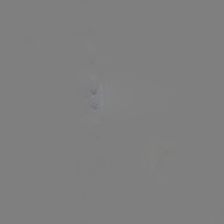

(27, 27)
(13, 13)
[(86.0, 137.0), (86.0, 137.0)]
generating feature_viz objective string for 81
deepviz image not found for 81, generating . . .
generating featviz with objective: features_3:81
------------------------------------------------------------------------------
        Layer (type)    map size      start       jump receptive_field 
        0             [224, 224]        0.5        1.0             1.0 
        1               [55, 55]        3.5        4.0            11.0 
        2               [55, 55]        3.5        4.0            11.0 
        3               [27, 27]        7.5        8.0            19.0 
        4               [27, 27]        7.5        8.0            51.0 
        5               [27, 27]        7.5        8.0            51.0 
        6               [13, 13]       15.5       16.0            67.0 
        7               [13, 13]       15.5       16.0            99.0 


  0%|          | 2/512 [00:00<00:10, 47.48it/s]

Interrupted optimization at step 3.



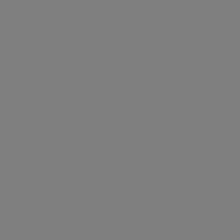

(27, 27)
(13, 13)
[(86.0, 137.0), (86.0, 137.0)]
generating feature_viz objective string for 83
deepviz image not found for 83, generating . . .
generating featviz with objective: features_3:83
------------------------------------------------------------------------------
        Layer (type)    map size      start       jump receptive_field 
        0             [224, 224]        0.5        1.0             1.0 
        1               [55, 55]        3.5        4.0            11.0 
        2               [55, 55]        3.5        4.0            11.0 
        3               [27, 27]        7.5        8.0            19.0 
        4               [27, 27]        7.5        8.0            51.0 
        5               [27, 27]        7.5        8.0            51.0 
        6               [13, 13]       15.5       16.0            67.0 
        7               [13, 13]       15.5       16.0            99.0 


  1%|          | 3/512 [00:00<00:11, 45.23it/s]

Interrupted optimization at step 4.



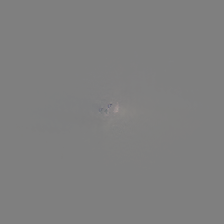

(27, 27)
(13, 13)
[(86.0, 137.0), (86.0, 137.0)]
generating feature_viz objective string for 84
deepviz image not found for 84, generating . . .
generating featviz with objective: features_3:84
------------------------------------------------------------------------------
        Layer (type)    map size      start       jump receptive_field 
        0             [224, 224]        0.5        1.0             1.0 
        1               [55, 55]        3.5        4.0            11.0 
        2               [55, 55]        3.5        4.0            11.0 
        3               [27, 27]        7.5        8.0            19.0 
        4               [27, 27]        7.5        8.0            51.0 
        5               [27, 27]        7.5        8.0            51.0 
        6               [13, 13]       15.5       16.0            67.0 
        7               [13, 13]       15.5       16.0            99.0 


  1%|          | 4/512 [00:00<00:10, 46.51it/s]

Interrupted optimization at step 5.



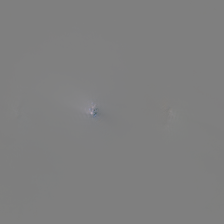

(27, 27)
(13, 13)
[(86.0, 137.0), (86.0, 137.0)]
generating feature_viz objective string for 93
deepviz image not found for 93, generating . . .
generating featviz with objective: features_3:93
------------------------------------------------------------------------------
        Layer (type)    map size      start       jump receptive_field 
        0             [224, 224]        0.5        1.0             1.0 
        1               [55, 55]        3.5        4.0            11.0 
        2               [55, 55]        3.5        4.0            11.0 
        3               [27, 27]        7.5        8.0            19.0 
        4               [27, 27]        7.5        8.0            51.0 
        5               [27, 27]        7.5        8.0            51.0 
        6               [13, 13]       15.5       16.0            67.0 
        7               [13, 13]       15.5       16.0            99.0 


  0%|          | 2/512 [00:00<00:10, 47.05it/s]

Interrupted optimization at step 3.



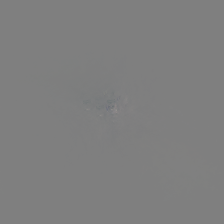

(27, 27)
(13, 13)
[(86.0, 137.0), (86.0, 137.0)]
generating feature_viz objective string for 95
deepviz image not found for 95, generating . . .
generating featviz with objective: features_3:95
------------------------------------------------------------------------------
        Layer (type)    map size      start       jump receptive_field 
        0             [224, 224]        0.5        1.0             1.0 
        1               [55, 55]        3.5        4.0            11.0 
        2               [55, 55]        3.5        4.0            11.0 
        3               [27, 27]        7.5        8.0            19.0 
        4               [27, 27]        7.5        8.0            51.0 
        5               [27, 27]        7.5        8.0            51.0 
        6               [13, 13]       15.5       16.0            67.0 
        7               [13, 13]       15.5       16.0            99.0 


  0%|          | 2/512 [00:00<00:13, 38.54it/s]

Interrupted optimization at step 3.



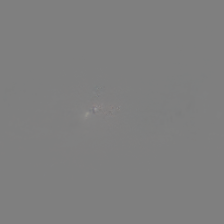

(27, 27)
(13, 13)
[(86.0, 137.0), (86.0, 137.0)]
generating feature_viz objective string for 99
deepviz image not found for 99, generating . . .
generating featviz with objective: features_3:99
------------------------------------------------------------------------------
        Layer (type)    map size      start       jump receptive_field 
        0             [224, 224]        0.5        1.0             1.0 
        1               [55, 55]        3.5        4.0            11.0 
        2               [55, 55]        3.5        4.0            11.0 
        3               [27, 27]        7.5        8.0            19.0 
        4               [27, 27]        7.5        8.0            51.0 
        5               [27, 27]        7.5        8.0            51.0 
        6               [13, 13]       15.5       16.0            67.0 
        7               [13, 13]       15.5       16.0            99.0 


  0%|          | 2/512 [00:00<00:11, 44.53it/s]

Interrupted optimization at step 3.



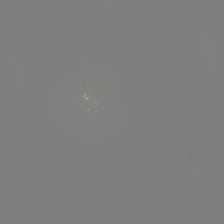

(27, 27)
(13, 13)
[(86.0, 137.0), (86.0, 137.0)]
generating feature_viz objective string for 101
deepviz image not found for 101, generating . . .
generating featviz with objective: features_3:101
------------------------------------------------------------------------------
        Layer (type)    map size      start       jump receptive_field 
        0             [224, 224]        0.5        1.0             1.0 
        1               [55, 55]        3.5        4.0            11.0 
        2               [55, 55]        3.5        4.0            11.0 
        3               [27, 27]        7.5        8.0            19.0 
        4               [27, 27]        7.5        8.0            51.0 
        5               [27, 27]        7.5        8.0            51.0 
        6               [13, 13]       15.5       16.0            67.0 
        7               [13, 13]       15.5       16.0            99.0 


  1%|          | 4/512 [00:00<00:11, 44.27it/s]

Interrupted optimization at step 5.



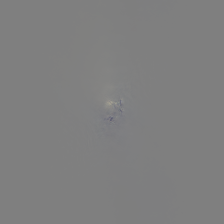

(27, 27)
(13, 13)
[(86.0, 137.0), (86.0, 137.0)]
generating feature_viz objective string for 103
deepviz image not found for 103, generating . . .
generating featviz with objective: features_3:103
------------------------------------------------------------------------------
        Layer (type)    map size      start       jump receptive_field 
        0             [224, 224]        0.5        1.0             1.0 
        1               [55, 55]        3.5        4.0            11.0 
        2               [55, 55]        3.5        4.0            11.0 
        3               [27, 27]        7.5        8.0            19.0 
        4               [27, 27]        7.5        8.0            51.0 
        5               [27, 27]        7.5        8.0            51.0 
        6               [13, 13]       15.5       16.0            67.0 
        7               [13, 13]       15.5       16.0            99.0 


  1%|          | 3/512 [00:00<00:12, 42.31it/s]

Interrupted optimization at step 4.



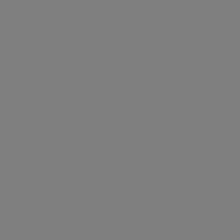

(27, 27)
(13, 13)
[(86.0, 137.0), (86.0, 137.0)]
generating feature_viz objective string for 112
deepviz image not found for 112, generating . . .
generating featviz with objective: features_3:112
------------------------------------------------------------------------------
        Layer (type)    map size      start       jump receptive_field 
        0             [224, 224]        0.5        1.0             1.0 
        1               [55, 55]        3.5        4.0            11.0 
        2               [55, 55]        3.5        4.0            11.0 
        3               [27, 27]        7.5        8.0            19.0 
        4               [27, 27]        7.5        8.0            51.0 
        5               [27, 27]        7.5        8.0            51.0 
        6               [13, 13]       15.5       16.0            67.0 
        7               [13, 13]       15.5       16.0            99.0 


  1%|          | 3/512 [00:00<00:11, 44.19it/s]

Interrupted optimization at step 4.



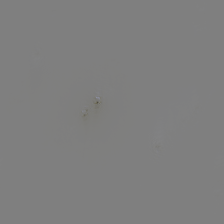

(27, 27)
(13, 13)
[(86.0, 137.0), (86.0, 137.0)]
generating feature_viz objective string for 120
deepviz image not found for 120, generating . . .
generating featviz with objective: features_3:120
------------------------------------------------------------------------------
        Layer (type)    map size      start       jump receptive_field 
        0             [224, 224]        0.5        1.0             1.0 
        1               [55, 55]        3.5        4.0            11.0 
        2               [55, 55]        3.5        4.0            11.0 
        3               [27, 27]        7.5        8.0            19.0 
        4               [27, 27]        7.5        8.0            51.0 
        5               [27, 27]        7.5        8.0            51.0 
        6               [13, 13]       15.5       16.0            67.0 
        7               [13, 13]       15.5       16.0            99.0 


  0%|          | 2/512 [00:00<00:11, 43.59it/s]

Interrupted optimization at step 3.



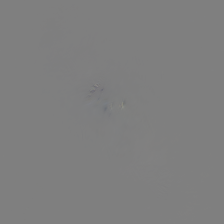

(27, 27)
(13, 13)
[(86.0, 137.0), (86.0, 137.0)]
generating feature_viz objective string for 122
deepviz image not found for 122, generating . . .
generating featviz with objective: features_3:122
------------------------------------------------------------------------------
        Layer (type)    map size      start       jump receptive_field 
        0             [224, 224]        0.5        1.0             1.0 
        1               [55, 55]        3.5        4.0            11.0 
        2               [55, 55]        3.5        4.0            11.0 
        3               [27, 27]        7.5        8.0            19.0 
        4               [27, 27]        7.5        8.0            51.0 
        5               [27, 27]        7.5        8.0            51.0 
        6               [13, 13]       15.5       16.0            67.0 
        7               [13, 13]       15.5       16.0            99.0 


  1%|          | 3/512 [00:00<00:11, 43.45it/s]


Interrupted optimization at step 4.



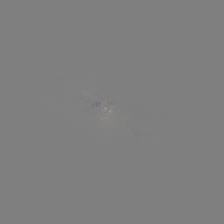

(27, 27)
(13, 13)
[(86.0, 137.0), (86.0, 137.0)]
generating feature_viz objective string for 130
deepviz image not found for 130, generating . . .
generating featviz with objective: features_3:130
------------------------------------------------------------------------------
        Layer (type)    map size      start       jump receptive_field 
        0             [224, 224]        0.5        1.0             1.0 
        1               [55, 55]        3.5        4.0            11.0 
        2               [55, 55]        3.5        4.0            11.0 
        3               [27, 27]        7.5        8.0            19.0 
        4               [27, 27]        7.5        8.0            51.0 
        5               [27, 27]        7.5        8.0            51.0 
        6               [13, 13]       15.5       16.0            67.0 
        7               [13, 13]       15.5       16.0            99.0 


  1%|          | 3/512 [00:00<00:12, 40.04it/s]


Interrupted optimization at step 4.



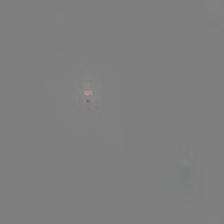

(27, 27)
(13, 13)
[(86.0, 137.0), (86.0, 137.0)]
generating feature_viz objective string for 131
deepviz image not found for 131, generating . . .
generating featviz with objective: features_3:131
------------------------------------------------------------------------------
        Layer (type)    map size      start       jump receptive_field 
        0             [224, 224]        0.5        1.0             1.0 
        1               [55, 55]        3.5        4.0            11.0 
        2               [55, 55]        3.5        4.0            11.0 
        3               [27, 27]        7.5        8.0            19.0 
        4               [27, 27]        7.5        8.0            51.0 
        5               [27, 27]        7.5        8.0            51.0 
        6               [13, 13]       15.5       16.0            67.0 
        7               [13, 13]       15.5       16.0            99.0 


  0%|          | 2/512 [00:00<00:11, 42.71it/s]

Interrupted optimization at step 3.



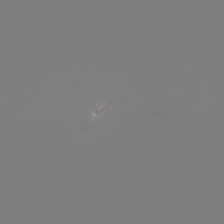

(27, 27)
(13, 13)
[(86.0, 137.0), (86.0, 137.0)]
generating feature_viz objective string for 133
deepviz image not found for 133, generating . . .
generating featviz with objective: features_3:133
------------------------------------------------------------------------------
        Layer (type)    map size      start       jump receptive_field 
        0             [224, 224]        0.5        1.0             1.0 
        1               [55, 55]        3.5        4.0            11.0 
        2               [55, 55]        3.5        4.0            11.0 
        3               [27, 27]        7.5        8.0            19.0 
        4               [27, 27]        7.5        8.0            51.0 
        5               [27, 27]        7.5        8.0            51.0 
        6               [13, 13]       15.5       16.0            67.0 
        7               [13, 13]       15.5       16.0            99.0 


  1%|          | 3/512 [00:00<00:13, 37.48it/s]

Interrupted optimization at step 4.



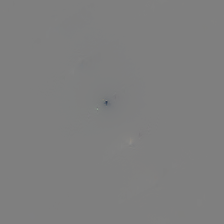

(27, 27)
(13, 13)
[(86.0, 137.0), (86.0, 137.0)]
generating feature_viz objective string for 135
deepviz image not found for 135, generating . . .
generating featviz with objective: features_3:135
------------------------------------------------------------------------------
        Layer (type)    map size      start       jump receptive_field 
        0             [224, 224]        0.5        1.0             1.0 
        1               [55, 55]        3.5        4.0            11.0 
        2               [55, 55]        3.5        4.0            11.0 
        3               [27, 27]        7.5        8.0            19.0 
        4               [27, 27]        7.5        8.0            51.0 
        5               [27, 27]        7.5        8.0            51.0 
        6               [13, 13]       15.5       16.0            67.0 
        7               [13, 13]       15.5       16.0            99.0 


  1%|          | 3/512 [00:00<00:14, 34.64it/s]

Interrupted optimization at step 4.



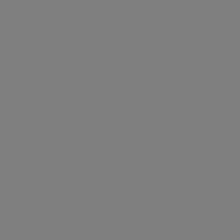

(27, 27)
(13, 13)
[(86.0, 137.0), (86.0, 137.0)]
generating feature_viz objective string for 136
deepviz image not found for 136, generating . . .
generating featviz with objective: features_3:136
------------------------------------------------------------------------------
        Layer (type)    map size      start       jump receptive_field 
        0             [224, 224]        0.5        1.0             1.0 
        1               [55, 55]        3.5        4.0            11.0 
        2               [55, 55]        3.5        4.0            11.0 
        3               [27, 27]        7.5        8.0            19.0 
        4               [27, 27]        7.5        8.0            51.0 
        5               [27, 27]        7.5        8.0            51.0 
        6               [13, 13]       15.5       16.0            67.0 
        7               [13, 13]       15.5       16.0            99.0 


  0%|          | 2/512 [00:00<00:12, 41.99it/s]

Interrupted optimization at step 3.



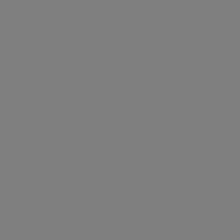

(27, 27)
(13, 13)
[(86.0, 137.0), (86.0, 137.0)]
generating feature_viz objective string for 138
deepviz image not found for 138, generating . . .
generating featviz with objective: features_3:138
------------------------------------------------------------------------------
        Layer (type)    map size      start       jump receptive_field 
        0             [224, 224]        0.5        1.0             1.0 
        1               [55, 55]        3.5        4.0            11.0 
        2               [55, 55]        3.5        4.0            11.0 
        3               [27, 27]        7.5        8.0            19.0 
        4               [27, 27]        7.5        8.0            51.0 
        5               [27, 27]        7.5        8.0            51.0 
        6               [13, 13]       15.5       16.0            67.0 
        7               [13, 13]       15.5       16.0            99.0 


  0%|          | 2/512 [00:00<00:13, 38.41it/s]

Interrupted optimization at step 3.



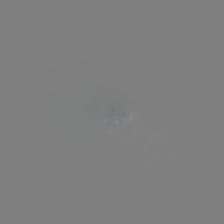

(27, 27)
(13, 13)
[(86.0, 137.0), (86.0, 137.0)]
generating feature_viz objective string for 140
deepviz image not found for 140, generating . . .
generating featviz with objective: features_3:140
------------------------------------------------------------------------------
        Layer (type)    map size      start       jump receptive_field 
        0             [224, 224]        0.5        1.0             1.0 
        1               [55, 55]        3.5        4.0            11.0 
        2               [55, 55]        3.5        4.0            11.0 
        3               [27, 27]        7.5        8.0            19.0 
        4               [27, 27]        7.5        8.0            51.0 
        5               [27, 27]        7.5        8.0            51.0 
        6               [13, 13]       15.5       16.0            67.0 
        7               [13, 13]       15.5       16.0            99.0 


  1%|          | 6/512 [00:00<00:12, 39.88it/s]

Interrupted optimization at step 7.



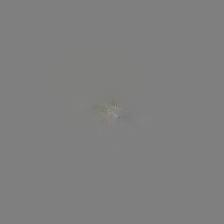

(27, 27)
(13, 13)
[(86.0, 137.0), (86.0, 137.0)]
generating feature_viz objective string for 150
deepviz image not found for 150, generating . . .
generating featviz with objective: features_3:150
------------------------------------------------------------------------------
        Layer (type)    map size      start       jump receptive_field 
        0             [224, 224]        0.5        1.0             1.0 
        1               [55, 55]        3.5        4.0            11.0 
        2               [55, 55]        3.5        4.0            11.0 
        3               [27, 27]        7.5        8.0            19.0 
        4               [27, 27]        7.5        8.0            51.0 
        5               [27, 27]        7.5        8.0            51.0 
        6               [13, 13]       15.5       16.0            67.0 
        7               [13, 13]       15.5       16.0            99.0 


100%|██████████| 512/512 [00:10<00:00, 49.64it/s]



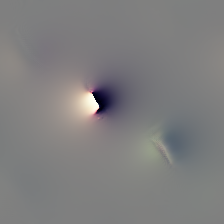

(27, 27)
(13, 13)
[(86.0, 137.0), (86.0, 137.0)]
generating feature_viz objective string for 151
deepviz image not found for 151, generating . . .
generating featviz with objective: features_3:151
------------------------------------------------------------------------------
        Layer (type)    map size      start       jump receptive_field 
        0             [224, 224]        0.5        1.0             1.0 
        1               [55, 55]        3.5        4.0            11.0 
        2               [55, 55]        3.5        4.0            11.0 
        3               [27, 27]        7.5        8.0            19.0 
        4               [27, 27]        7.5        8.0            51.0 
        5               [27, 27]        7.5        8.0            51.0 
        6               [13, 13]       15.5       16.0            67.0 
        7               [13, 13]       15.5       16.0            99.0 


100%|██████████| 512/512 [00:10<00:00, 49.82it/s]



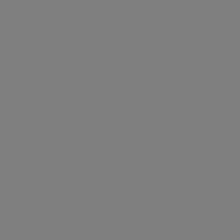

(27, 27)
(13, 13)
[(86.0, 137.0), (86.0, 137.0)]
generating feature_viz objective string for 152
deepviz image not found for 152, generating . . .
generating featviz with objective: features_3:152
------------------------------------------------------------------------------
        Layer (type)    map size      start       jump receptive_field 
        0             [224, 224]        0.5        1.0             1.0 
        1               [55, 55]        3.5        4.0            11.0 
        2               [55, 55]        3.5        4.0            11.0 
        3               [27, 27]        7.5        8.0            19.0 
        4               [27, 27]        7.5        8.0            51.0 
        5               [27, 27]        7.5        8.0            51.0 
        6               [13, 13]       15.5       16.0            67.0 
        7               [13, 13]       15.5       16.0            99.0 


100%|██████████| 512/512 [00:10<00:00, 48.94it/s]



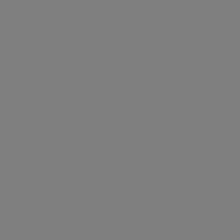

(27, 27)
(13, 13)
[(86.0, 137.0), (86.0, 137.0)]
generating feature_viz objective string for 155
deepviz image not found for 155, generating . . .
generating featviz with objective: features_3:155
------------------------------------------------------------------------------
        Layer (type)    map size      start       jump receptive_field 
        0             [224, 224]        0.5        1.0             1.0 
        1               [55, 55]        3.5        4.0            11.0 
        2               [55, 55]        3.5        4.0            11.0 
        3               [27, 27]        7.5        8.0            19.0 
        4               [27, 27]        7.5        8.0            51.0 
        5               [27, 27]        7.5        8.0            51.0 
        6               [13, 13]       15.5       16.0            67.0 
        7               [13, 13]       15.5       16.0            99.0 


100%|██████████| 512/512 [00:10<00:00, 48.87it/s]



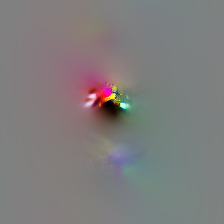

(27, 27)
(13, 13)
[(86.0, 137.0), (86.0, 137.0)]
generating feature_viz objective string for 159
deepviz image not found for 159, generating . . .
generating featviz with objective: features_3:159
------------------------------------------------------------------------------
        Layer (type)    map size      start       jump receptive_field 
        0             [224, 224]        0.5        1.0             1.0 
        1               [55, 55]        3.5        4.0            11.0 
        2               [55, 55]        3.5        4.0            11.0 
        3               [27, 27]        7.5        8.0            19.0 
        4               [27, 27]        7.5        8.0            51.0 
        5               [27, 27]        7.5        8.0            51.0 
        6               [13, 13]       15.5       16.0            67.0 
        7               [13, 13]       15.5       16.0            99.0 


 69%|██████▉   | 355/512 [00:06<00:02, 54.57it/s]

Interrupted optimization at step 356.



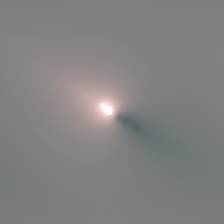

(27, 27)
(13, 13)
[(86.0, 137.0), (86.0, 137.0)]
generating feature_viz objective string for 161
deepviz image not found for 161, generating . . .
generating featviz with objective: features_3:161
------------------------------------------------------------------------------
        Layer (type)    map size      start       jump receptive_field 
        0             [224, 224]        0.5        1.0             1.0 
        1               [55, 55]        3.5        4.0            11.0 
        2               [55, 55]        3.5        4.0            11.0 
        3               [27, 27]        7.5        8.0            19.0 
        4               [27, 27]        7.5        8.0            51.0 
        5               [27, 27]        7.5        8.0            51.0 
        6               [13, 13]       15.5       16.0            67.0 
        7               [13, 13]       15.5       16.0            99.0 


  1%|          | 3/512 [00:00<00:12, 39.68it/s]

Interrupted optimization at step 4.



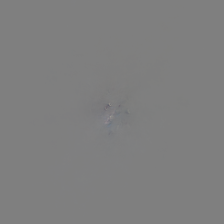

(27, 27)
(13, 13)
[(86.0, 137.0), (86.0, 137.0)]
generating feature_viz objective string for 162
deepviz image not found for 162, generating . . .
generating featviz with objective: features_3:162
------------------------------------------------------------------------------
        Layer (type)    map size      start       jump receptive_field 
        0             [224, 224]        0.5        1.0             1.0 
        1               [55, 55]        3.5        4.0            11.0 
        2               [55, 55]        3.5        4.0            11.0 
        3               [27, 27]        7.5        8.0            19.0 
        4               [27, 27]        7.5        8.0            51.0 
        5               [27, 27]        7.5        8.0            51.0 
        6               [13, 13]       15.5       16.0            67.0 
        7               [13, 13]       15.5       16.0            99.0 


  0%|          | 2/512 [00:00<00:11, 43.46it/s]

Interrupted optimization at step 3.



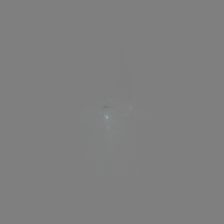

(27, 27)
(13, 13)
[(86.0, 137.0), (86.0, 137.0)]
generating feature_viz objective string for 165
deepviz image not found for 165, generating . . .
generating featviz with objective: features_3:165
------------------------------------------------------------------------------
        Layer (type)    map size      start       jump receptive_field 
        0             [224, 224]        0.5        1.0             1.0 
        1               [55, 55]        3.5        4.0            11.0 
        2               [55, 55]        3.5        4.0            11.0 
        3               [27, 27]        7.5        8.0            19.0 
        4               [27, 27]        7.5        8.0            51.0 
        5               [27, 27]        7.5        8.0            51.0 
        6               [13, 13]       15.5       16.0            67.0 
        7               [13, 13]       15.5       16.0            99.0 


  0%|          | 1/512 [00:00<00:15, 32.54it/s]

Interrupted optimization at step 2.



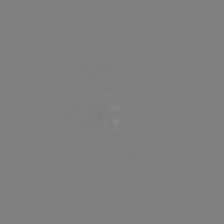

(27, 27)
(13, 13)
[(86.0, 137.0), (86.0, 137.0)]
generating feature_viz objective string for 168
deepviz image not found for 168, generating . . .
generating featviz with objective: features_3:168
------------------------------------------------------------------------------
        Layer (type)    map size      start       jump receptive_field 
        0             [224, 224]        0.5        1.0             1.0 
        1               [55, 55]        3.5        4.0            11.0 
        2               [55, 55]        3.5        4.0            11.0 
        3               [27, 27]        7.5        8.0            19.0 
        4               [27, 27]        7.5        8.0            51.0 
        5               [27, 27]        7.5        8.0            51.0 
        6               [13, 13]       15.5       16.0            67.0 
        7               [13, 13]       15.5       16.0            99.0 


100%|██████████| 512/512 [00:10<00:00, 50.62it/s]



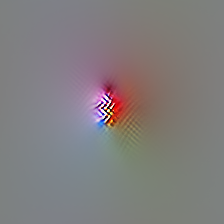

(27, 27)
(13, 13)
[(86.0, 137.0), (86.0, 137.0)]
generating feature_viz objective string for 170
deepviz image not found for 170, generating . . .
generating featviz with objective: features_3:170
------------------------------------------------------------------------------
        Layer (type)    map size      start       jump receptive_field 
        0             [224, 224]        0.5        1.0             1.0 
        1               [55, 55]        3.5        4.0            11.0 
        2               [55, 55]        3.5        4.0            11.0 
        3               [27, 27]        7.5        8.0            19.0 
        4               [27, 27]        7.5        8.0            51.0 
        5               [27, 27]        7.5        8.0            51.0 
        6               [13, 13]       15.5       16.0            67.0 
        7               [13, 13]       15.5       16.0            99.0 


 66%|██████▌   | 339/512 [00:06<00:03, 49.89it/s]

Interrupted optimization at step 340.



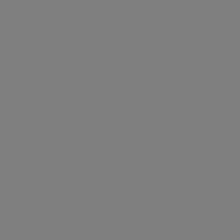

(27, 27)
(13, 13)
[(86.0, 137.0), (86.0, 137.0)]
generating feature_viz objective string for 172
deepviz image not found for 172, generating . . .
generating featviz with objective: features_3:172
------------------------------------------------------------------------------
        Layer (type)    map size      start       jump receptive_field 
        0             [224, 224]        0.5        1.0             1.0 
        1               [55, 55]        3.5        4.0            11.0 
        2               [55, 55]        3.5        4.0            11.0 
        3               [27, 27]        7.5        8.0            19.0 
        4               [27, 27]        7.5        8.0            51.0 
        5               [27, 27]        7.5        8.0            51.0 
        6               [13, 13]       15.5       16.0            67.0 
        7               [13, 13]       15.5       16.0            99.0 


  1%|          | 6/512 [00:00<00:12, 40.20it/s]

Interrupted optimization at step 7.



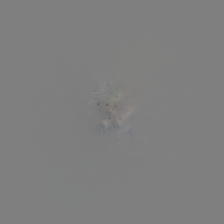

(27, 27)
(13, 13)
[(86.0, 137.0), (86.0, 137.0)]
generating feature_viz objective string for 174
deepviz image not found for 174, generating . . .
generating featviz with objective: features_3:174
------------------------------------------------------------------------------
        Layer (type)    map size      start       jump receptive_field 
        0             [224, 224]        0.5        1.0             1.0 
        1               [55, 55]        3.5        4.0            11.0 
        2               [55, 55]        3.5        4.0            11.0 
        3               [27, 27]        7.5        8.0            19.0 
        4               [27, 27]        7.5        8.0            51.0 
        5               [27, 27]        7.5        8.0            51.0 
        6               [13, 13]       15.5       16.0            67.0 
        7               [13, 13]       15.5       16.0            99.0 


  0%|          | 0/512 [00:00<?, ?it/s]

Interrupted optimization at step 1.



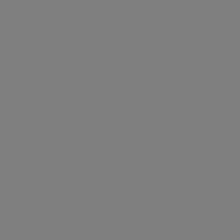

(27, 27)
(13, 13)
[(86.0, 137.0), (86.0, 137.0)]
generating feature_viz objective string for 175
deepviz image not found for 175, generating . . .
generating featviz with objective: features_3:175
------------------------------------------------------------------------------
        Layer (type)    map size      start       jump receptive_field 
        0             [224, 224]        0.5        1.0             1.0 
        1               [55, 55]        3.5        4.0            11.0 
        2               [55, 55]        3.5        4.0            11.0 
        3               [27, 27]        7.5        8.0            19.0 
        4               [27, 27]        7.5        8.0            51.0 
        5               [27, 27]        7.5        8.0            51.0 
        6               [13, 13]       15.5       16.0            67.0 
        7               [13, 13]       15.5       16.0            99.0 


  0%|          | 2/512 [00:00<00:12, 40.20it/s]

Interrupted optimization at step 3.



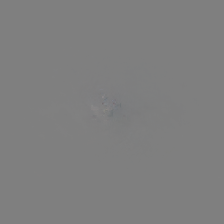

(27, 27)
(13, 13)
[(86.0, 137.0), (86.0, 137.0)]
generating feature_viz objective string for 179
deepviz image not found for 179, generating . . .
generating featviz with objective: features_3:179
------------------------------------------------------------------------------
        Layer (type)    map size      start       jump receptive_field 
        0             [224, 224]        0.5        1.0             1.0 
        1               [55, 55]        3.5        4.0            11.0 
        2               [55, 55]        3.5        4.0            11.0 
        3               [27, 27]        7.5        8.0            19.0 
        4               [27, 27]        7.5        8.0            51.0 
        5               [27, 27]        7.5        8.0            51.0 
        6               [13, 13]       15.5       16.0            67.0 
        7               [13, 13]       15.5       16.0            99.0 


  1%|          | 4/512 [00:00<00:09, 54.54it/s]

Interrupted optimization at step 5.



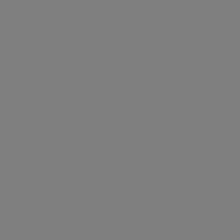

(27, 27)
(13, 13)
[(86.0, 137.0), (86.0, 137.0)]
generating feature_viz objective string for 180
deepviz image not found for 180, generating . . .
generating featviz with objective: features_3:180
------------------------------------------------------------------------------
        Layer (type)    map size      start       jump receptive_field 
        0             [224, 224]        0.5        1.0             1.0 
        1               [55, 55]        3.5        4.0            11.0 
        2               [55, 55]        3.5        4.0            11.0 
        3               [27, 27]        7.5        8.0            19.0 
        4               [27, 27]        7.5        8.0            51.0 
        5               [27, 27]        7.5        8.0            51.0 
        6               [13, 13]       15.5       16.0            67.0 
        7               [13, 13]       15.5       16.0            99.0 


  0%|          | 2/512 [00:00<00:14, 34.87it/s]

Interrupted optimization at step 3.



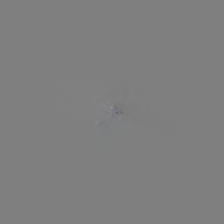

(27, 27)
(13, 13)
[(86.0, 137.0), (86.0, 137.0)]
generating feature_viz objective string for 181
deepviz image not found for 181, generating . . .
generating featviz with objective: features_3:181
------------------------------------------------------------------------------
        Layer (type)    map size      start       jump receptive_field 
        0             [224, 224]        0.5        1.0             1.0 
        1               [55, 55]        3.5        4.0            11.0 
        2               [55, 55]        3.5        4.0            11.0 
        3               [27, 27]        7.5        8.0            19.0 
        4               [27, 27]        7.5        8.0            51.0 
        5               [27, 27]        7.5        8.0            51.0 
        6               [13, 13]       15.5       16.0            67.0 
        7               [13, 13]       15.5       16.0            99.0 


  0%|          | 0/512 [00:00<?, ?it/s]

Interrupted optimization at step 1.



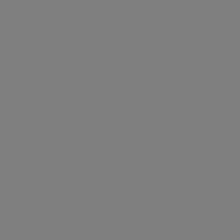

(27, 27)
(13, 13)
[(86.0, 137.0), (86.0, 137.0)]
generating feature_viz objective string for 183
deepviz image not found for 183, generating . . .
generating featviz with objective: features_3:183
------------------------------------------------------------------------------
        Layer (type)    map size      start       jump receptive_field 
        0             [224, 224]        0.5        1.0             1.0 
        1               [55, 55]        3.5        4.0            11.0 
        2               [55, 55]        3.5        4.0            11.0 
        3               [27, 27]        7.5        8.0            19.0 
        4               [27, 27]        7.5        8.0            51.0 
        5               [27, 27]        7.5        8.0            51.0 
        6               [13, 13]       15.5       16.0            67.0 
        7               [13, 13]       15.5       16.0            99.0 


  1%|          | 4/512 [00:00<00:11, 44.24it/s]

Interrupted optimization at step 5.



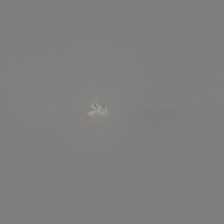

(27, 27)
(13, 13)
[(86.0, 137.0), (86.0, 137.0)]
generating feature_viz objective string for 184
deepviz image not found for 184, generating . . .
generating featviz with objective: features_3:184
------------------------------------------------------------------------------
        Layer (type)    map size      start       jump receptive_field 
        0             [224, 224]        0.5        1.0             1.0 
        1               [55, 55]        3.5        4.0            11.0 
        2               [55, 55]        3.5        4.0            11.0 
        3               [27, 27]        7.5        8.0            19.0 
        4               [27, 27]        7.5        8.0            51.0 
        5               [27, 27]        7.5        8.0            51.0 
        6               [13, 13]       15.5       16.0            67.0 
        7               [13, 13]       15.5       16.0            99.0 


  0%|          | 0/512 [00:00<?, ?it/s]

Interrupted optimization at step 1.



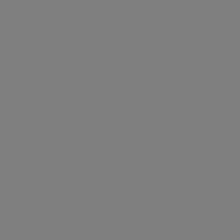

(27, 27)
(13, 13)
[(86.0, 137.0), (86.0, 137.0)]
generating feature_viz objective string for 186
deepviz image not found for 186, generating . . .
generating featviz with objective: features_3:186
------------------------------------------------------------------------------
        Layer (type)    map size      start       jump receptive_field 
        0             [224, 224]        0.5        1.0             1.0 
        1               [55, 55]        3.5        4.0            11.0 
        2               [55, 55]        3.5        4.0            11.0 
        3               [27, 27]        7.5        8.0            19.0 
        4               [27, 27]        7.5        8.0            51.0 
        5               [27, 27]        7.5        8.0            51.0 
        6               [13, 13]       15.5       16.0            67.0 
        7               [13, 13]       15.5       16.0            99.0 


  0%|          | 2/512 [00:00<00:12, 42.14it/s]

Interrupted optimization at step 3.



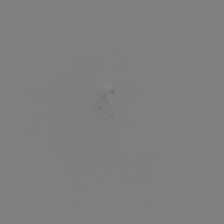

(27, 27)
(13, 13)
[(86.0, 137.0), (86.0, 137.0)]
generating feature_viz objective string for 188
deepviz image not found for 188, generating . . .
generating featviz with objective: features_3:188
------------------------------------------------------------------------------
        Layer (type)    map size      start       jump receptive_field 
        0             [224, 224]        0.5        1.0             1.0 
        1               [55, 55]        3.5        4.0            11.0 
        2               [55, 55]        3.5        4.0            11.0 
        3               [27, 27]        7.5        8.0            19.0 
        4               [27, 27]        7.5        8.0            51.0 
        5               [27, 27]        7.5        8.0            51.0 
        6               [13, 13]       15.5       16.0            67.0 
        7               [13, 13]       15.5       16.0            99.0 


  1%|          | 3/512 [00:00<00:11, 43.51it/s]


Interrupted optimization at step 4.



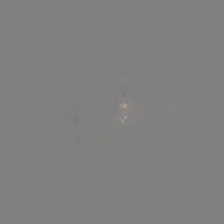

(27, 27)
(13, 13)
[(86.0, 137.0), (86.0, 137.0)]
generating feature_viz objective string for 189
deepviz image not found for 189, generating . . .
generating featviz with objective: features_3:189
------------------------------------------------------------------------------
        Layer (type)    map size      start       jump receptive_field 
        0             [224, 224]        0.5        1.0             1.0 
        1               [55, 55]        3.5        4.0            11.0 
        2               [55, 55]        3.5        4.0            11.0 
        3               [27, 27]        7.5        8.0            19.0 
        4               [27, 27]        7.5        8.0            51.0 
        5               [27, 27]        7.5        8.0            51.0 
        6               [13, 13]       15.5       16.0            67.0 
        7               [13, 13]       15.5       16.0            99.0 


  0%|          | 1/512 [00:00<00:11, 42.80it/s]

Interrupted optimization at step 2.



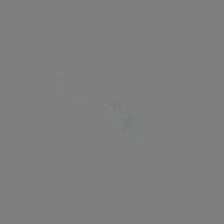

(27, 27)
(13, 13)
[(86.0, 137.0), (86.0, 137.0)]
generating feature_viz objective string for 195
deepviz image not found for 195, generating . . .
generating featviz with objective: features_3:195
------------------------------------------------------------------------------
        Layer (type)    map size      start       jump receptive_field 
        0             [224, 224]        0.5        1.0             1.0 
        1               [55, 55]        3.5        4.0            11.0 
        2               [55, 55]        3.5        4.0            11.0 
        3               [27, 27]        7.5        8.0            19.0 
        4               [27, 27]        7.5        8.0            51.0 
        5               [27, 27]        7.5        8.0            51.0 
        6               [13, 13]       15.5       16.0            67.0 
        7               [13, 13]       15.5       16.0            99.0 


  0%|          | 1/512 [00:00<00:17, 29.62it/s]

Interrupted optimization at step 2.



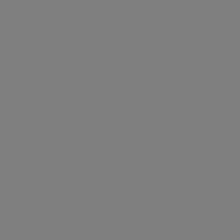

(27, 27)
(13, 13)
[(86.0, 137.0), (86.0, 137.0)]
generating feature_viz objective string for 196
deepviz image not found for 196, generating . . .
generating featviz with objective: features_3:196
------------------------------------------------------------------------------
        Layer (type)    map size      start       jump receptive_field 
        0             [224, 224]        0.5        1.0             1.0 
        1               [55, 55]        3.5        4.0            11.0 
        2               [55, 55]        3.5        4.0            11.0 
        3               [27, 27]        7.5        8.0            19.0 
        4               [27, 27]        7.5        8.0            51.0 
        5               [27, 27]        7.5        8.0            51.0 
        6               [13, 13]       15.5       16.0            67.0 
        7               [13, 13]       15.5       16.0            99.0 


  0%|          | 1/512 [00:00<00:13, 38.57it/s]

Interrupted optimization at step 2.



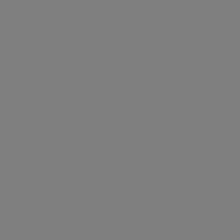

(27, 27)
(13, 13)
[(86.0, 137.0), (86.0, 137.0)]
generating feature_viz objective string for 198
deepviz image not found for 198, generating . . .
generating featviz with objective: features_3:198
------------------------------------------------------------------------------
        Layer (type)    map size      start       jump receptive_field 
        0             [224, 224]        0.5        1.0             1.0 
        1               [55, 55]        3.5        4.0            11.0 
        2               [55, 55]        3.5        4.0            11.0 
        3               [27, 27]        7.5        8.0            19.0 
        4               [27, 27]        7.5        8.0            51.0 
        5               [27, 27]        7.5        8.0            51.0 
        6               [13, 13]       15.5       16.0            67.0 
        7               [13, 13]       15.5       16.0            99.0 


  1%|          | 3/512 [00:00<00:11, 42.62it/s]


Interrupted optimization at step 4.



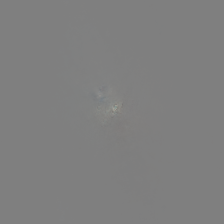

(27, 27)
(13, 13)
[(86.0, 137.0), (86.0, 137.0)]
generating feature_viz objective string for 202
deepviz image not found for 202, generating . . .
generating featviz with objective: features_3:202
------------------------------------------------------------------------------
        Layer (type)    map size      start       jump receptive_field 
        0             [224, 224]        0.5        1.0             1.0 
        1               [55, 55]        3.5        4.0            11.0 
        2               [55, 55]        3.5        4.0            11.0 
        3               [27, 27]        7.5        8.0            19.0 
        4               [27, 27]        7.5        8.0            51.0 
        5               [27, 27]        7.5        8.0            51.0 
        6               [13, 13]       15.5       16.0            67.0 
        7               [13, 13]       15.5       16.0            99.0 


  0%|          | 0/512 [00:00<?, ?it/s]

Interrupted optimization at step 1.



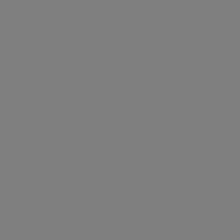

(27, 27)
(13, 13)
[(86.0, 137.0), (86.0, 137.0)]
generating feature_viz objective string for 210
deepviz image not found for 210, generating . . .
generating featviz with objective: features_3:210
------------------------------------------------------------------------------
        Layer (type)    map size      start       jump receptive_field 
        0             [224, 224]        0.5        1.0             1.0 
        1               [55, 55]        3.5        4.0            11.0 
        2               [55, 55]        3.5        4.0            11.0 
        3               [27, 27]        7.5        8.0            19.0 
        4               [27, 27]        7.5        8.0            51.0 
        5               [27, 27]        7.5        8.0            51.0 
        6               [13, 13]       15.5       16.0            67.0 
        7               [13, 13]       15.5       16.0            99.0 


  0%|          | 1/512 [00:00<00:14, 35.91it/s]

Interrupted optimization at step 2.



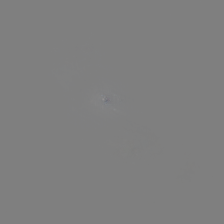

(27, 27)
(13, 13)
[(86.0, 137.0), (86.0, 137.0)]
generating feature_viz objective string for 211
deepviz image not found for 211, generating . . .
generating featviz with objective: features_3:211
------------------------------------------------------------------------------
        Layer (type)    map size      start       jump receptive_field 
        0             [224, 224]        0.5        1.0             1.0 
        1               [55, 55]        3.5        4.0            11.0 
        2               [55, 55]        3.5        4.0            11.0 
        3               [27, 27]        7.5        8.0            19.0 
        4               [27, 27]        7.5        8.0            51.0 
        5               [27, 27]        7.5        8.0            51.0 
        6               [13, 13]       15.5       16.0            67.0 
        7               [13, 13]       15.5       16.0            99.0 


  0%|          | 2/512 [00:00<00:12, 41.59it/s]

Interrupted optimization at step 3.



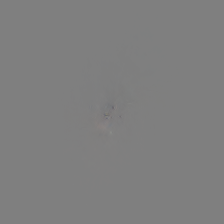

(27, 27)
(13, 13)
[(86.0, 137.0), (86.0, 137.0)]
generating feature_viz objective string for 212
deepviz image not found for 212, generating . . .
generating featviz with objective: features_3:212


KeyboardInterrupt: 

In [9]:
launch_circuit_gui(circuit,mask,model,weight_rank,port=8050,viz_folder=None,device=device)

In [259]:
from PIL import ImageEnhance, Image, ImageOps
import math

def color_channel_kernel_2_image(kernel):
    
    #curve = lambda x: min(math.log(x+.1,10)+1,1)
    curve = lambda x: min((math.log(x+1/2,2)+1)/1.6,1)
    vcurve =  np.vectorize(curve)

    kernel = kernel.detach().cpu().numpy()
    kernel[kernel < 0] = 0
    kernel = (kernel - kernel.min())/(kernel.max()-kernel.min())
    kernel = kernel.transpose(1,2,0)
    kernel = vcurve(kernel)
    kernel = (kernel * 255).astype(np.uint8)
    image = Image.fromarray(kernel)
    image = image.resize((100,100),Image.BILINEAR)
    
    factor = 2 #brightens the image
    enhancer = ImageEnhance.Brightness(image)
    image = enhancer.enhance(factor)
    return image

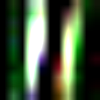

In [270]:
color_channel_kernel_2_image(model.features[0].weight[24])

1

In [244]:
kernel = model.features[0].weight[4]
kernel = kernel.detach().cpu().numpy()
kernel[kernel < 0] = 0
kernel = (kernel - kernel.min())/(kernel.max()-kernel.min())
kernel = kernel.transpose(1,2,0)
kernel = math.log(kernel+.1,10)+1

TypeError: only size-1 arrays can be converted to Python scalars

In [168]:
from PIL import ImageEnhance

In [217]:
kernel = model.features[0].weight[4]

In [207]:
kernel = kernel.detach().cpu().numpy()

In [208]:
kernel[kernel < 0] = 0

In [209]:
kernel = (kernel - kernel.min())/(kernel.max()-kernel.min())

In [210]:
kernel = kernel.transpose(1,2,0)

In [211]:
kernel = (kernel * 255).astype(np.uint8)

In [212]:
kernel.shape

(11, 11, 3)

In [213]:
image = Image.fromarray(kernel)

In [214]:
image = image.resize((100,100),Image.BILINEAR)

In [215]:
enhancer = ImageEnhance.Brightness(image)

factor = 2 #brightens the image
image = enhancer.enhance(factor)


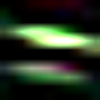

In [216]:
image

In [126]:
kernel = kernel*255

In [43]:
kernel.shape

(3, 11, 11)

In [42]:
im = Image.fromarray(np.uint8(kernel))

TypeError: Cannot handle this data type: (1, 1, 11), |u1

In [31]:
kernel = kernel.astype(np.uint8)

In [34]:
#kernel = kernel.transpose(2,0,1)

In [36]:
from PIL import Image, ImageOps

pil_image=Image.fromarray(kernel).convert('RGB')
pil_image.show()


TypeError: Cannot handle this data type: (1, 1, 11), |u1

In [12]:
def circuit_2_2d_circuit_diagram(circuit,mask,orig_model,ranks,num_hoverpoints=4,use_img_nodes=False,normed_ranks=True):
    
    #kernels
    kernels = get_kernels_Conv2d_modules(model)
    kernel_posneg = gen_kernel_posneg(kernels)
    kernel_colors = posneg_to_rgb(kernel_posneg)
    
    
    #spacing
    layer_offset = 5
    vert_offset = 1
    
    #naming
    layer_nodes = get_model_filterids(model)
    
    
    #dataframes
    edge_df = gen_circuit_model_mapping_df(orig_model,mask,ranks,version = 'edges')
    node_df = gen_circuit_model_mapping_df(orig_model,mask,ranks,version = 'nodes')
    
    #ranks
    if normed_ranks:
        rank_type = 'norm_rank'
    else:
        rank_type = 'rank'
    
    
    #img nodes
    if use_img_nodes:
        imgnode_positions = {'X':[-layer_offset,-layer_offset,-layer_offset],'Y':[2,0,-2]}

        imgnode_trace=go.Scatter(x=imgnode_positions['X'],
               y=imgnode_positions['Y'],
               mode='markers',
               name='image channels',
               marker=dict(symbol='square',
                             size=8,
                             opacity=.99,
                             color=params['imgnode_colors'],
                             #colorscale='Viridis',
                             line=dict(color='rgb(50,50,50)', width=.5)
                             ),
               text=params['imgnode_names'],
               hoverinfo='text'
               )

        imgnode_traces = [imgnode_trace]

    #NODE TRACES
    pos_dict_nodes = {}
    node_traces = []
    for layer in list(node_df['layer'].unique()):
        #add nodes

        within_layer_ids = list(node_df.loc[node_df['layer']==layer]['node_num_by_layer'])
        scores = list(node_df.loc[node_df['layer']==layer][rank_type])
        ids = list(node_df.loc[node_df['layer']==layer]['node_num'])
        #print(np.dstack((ids,within_layer_ids,scores)).shape)
        #print(np.dstack((ids,within_layer_ids,scores)))
        # hovertext = ['<b>%{id}</b>' +
        # 			'<br><i>layerwise ID</i>: %{within_layer_id}'+
        # 			'<br><i>Score</i>: %{score}<br>'
        # 			 for id, within_layer_id, score in
        # 			 zip(ids, within_layer_ids, scores)]
        #print(hovertext) 
        x_positions = []
        y_positions = []
        y_adjustment = (len(within_layer_ids)-1)/2*vert_offset
        for i in range(len(within_layer_ids)):
            x_positions.append(layer*layer_offset)
            y_positions.append(i*vert_offset-y_adjustment)
        node_trace=go.Scatter(x=x_positions,
                   y=y_positions,
                   mode='markers',
                   name=list(node_df.loc[node_df['layer']==layer]['layer_name'].unique())[0],
                   marker=dict(symbol='circle',
                                 size=6,
                                 color='rgba(50,50,50,0)',
                                 opacity=0,
                                 #colorscale='Viridis',
                                 line=dict(color='rgba(50,50,50,0)', width=.5)
                                 ),
                   text=ids,
                   #customdata = np.dstack((ids,within_layer_ids,scores)),
                   customdata = np.stack((ids,within_layer_ids,scores),axis=-1),
                   hovertemplate =	'<b>%{customdata[0]}</b>' +
                            '<br><i>layerwise ID</i>: %{customdata[1]}'+
                            '<br><i>Score</i>: %{customdata[2]:.3f}<br>'
                   #hoverinfo='text'
                   )

        node_traces.append(node_trace)
        pos_dict_nodes[layer] = {'name':ids,'X':x_positions,'Y':y_positions}
     
    
    #EDGE TRACES
    edge_traces = []
    pos_dict_edges = {}
    for layer in list(edge_df['layer'].unique()):  
        
        if layer == 0 and not use_img_nodes:
            continue
            
        pos_dict_edges[layer] = {'name':[],'X':[],'Y':[]}
        legendgroup = layernum2name(layer ,title = 'edges')

        #edge_widths = []
        #names = []
        #colors = []
        for row in edge_df.loc[edge_df['layer']==layer].itertuples():
            showlegend = False
            if getattr(row, rank_type) > .999:
                showlegend = True
            #positions
            edge_positions = {'X':[],'Y':[]}
            for dim in ['X','Y']:
                end_pos = pos_dict_nodes[layer][dim][pos_dict_nodes[layer]['name'].index(layer_nodes[layer][1][row.out_channel])]
                if layer != 0:
                    start_pos = pos_dict_nodes[layer-1][dim][pos_dict_nodes[layer-1]['name'].index(layer_nodes[layer-1][1][row.in_channel])]
                else:
                    start_pos = imgnode_positions[dim][row.in_channel]

                step = (end_pos-start_pos)/(num_hoverpoints+1)
                points = [start_pos]
                for i in range(1,num_hoverpoints+1):
                    points.append(start_pos+i*step)
                points.append(end_pos)
                edge_positions[dim]=points
            #widths
            edge_width = circuit_edge_width_scaling(getattr(row, rank_type))
            #edge_widths.append(edge_width_scaling(getattr(row, rank_type)))
            #names
            out_node = layer_nodes[row.layer][1][row.out_channel]
            if row.layer != 0:
                in_node = layer_nodes[row.layer-1][1][row.in_channel]
            else:
                in_node = params['imgnode_names'][row.in_channel]
            #names.append(str(in_node)+'-'+str(out_node))
            edge_name = str(in_node)+'-'+str(out_node)
            #color
            if kernel_colors is None:
                alpha = edge_color_scaling(getattr(row, rank_type))
                #colors.append(params['layer_colors'][layer%len(params['layer_colors'])]+str(round(alpha,3))+')')
                edge_color = params['layer_colors'][layer%len(params['layer_colors'])]+str(round(alpha,3))+')'
            else:
                #colors.append(color_vec_2_str(kernel_colors[int(layer)][int(row.out_channel)][int(row.in_channel)]))
                edge_color = color_vec_2_str(kernel_colors[int(layer)][int(row.out_channel)][int(row.in_channel)])
            edge_trace=go.Scatter(x=edge_positions['X'],
                            y=edge_positions['Y'],
                            legendgroup=legendgroup,
                            showlegend=showlegend,
                            name=layer_nodes[layer][0],
                            mode='lines',
                            #line=dict(color=edge_colors_dict[layer], width=1.5),
                            line=dict(color=edge_color, width=edge_width),
                            text = edge_name,
                            hoverinfo='text'
                            )
            edge_traces.append(edge_trace)
            pos_dict_edges[layer]['name'].append(edge_name)
            pos_dict_edges[layer]['X'].append(edge_positions['X'])
            pos_dict_edges[layer]['Y'].append(edge_positions['Y']) 
            
    #trace just for storing data
    misc_trace=go.Scatter(x=[-layer_offset-.5],
                y=[-2.5],
                showlegend=False,
                name='misc',
                mode='markers',
                marker=dict(symbol='circle',
                 size=6,
                 color='rgba(255,255,255,0)',
                 opacity=0,
                 #colorscale='Viridis',
                 line=dict(color='rgba(255,255,255,0)', width=.5)
                 ),

                text = 'full', #text info storing full or partial graph
                hoverinfo='skip'
                )
    
    combined_traces = node_traces+edge_traces+[misc_trace]
    if use_img_nodes:
        combined_traces = combinde_traces+imgnode_traces
        
    return combined_traces, pos_dict_nodes, pos_dict_edges


    

In [14]:
circuit_2_2d_circuit_diagram(circuit,mask,model,weight_rank,use_img_nodes=False,normed_ranks=True)

([Scatter({
      'customdata': array([[0.00000000e+00, 0.00000000e+00, 1.10760480e-01],
                           [1.00000000e+00, 1.00000000e+00, 8.20544921e-03],
                           [2.00000000e+00, 2.00000000e+00, 3.84208530e-01],
                           [3.00000000e+00, 3.00000000e+00, 1.05074033e-01],
                           [4.00000000e+00, 4.00000000e+00, 1.02635860e-01],
                           [5.00000000e+00, 5.00000000e+00, 5.80450147e-02],
                           [6.00000000e+00, 6.00000000e+00, 1.09399430e-01],
                           [7.00000000e+00, 7.00000000e+00, 1.19391434e-01],
                           [8.00000000e+00, 8.00000000e+00, 3.27255398e-01],
                           [9.00000000e+00, 9.00000000e+00, 2.21579880e-01],
                           [1.00000000e+01, 1.00000000e+01, 7.17978626e-02],
                           [1.10000000e+01, 1.10000000e+01, 6.32680357e-02],
                           [1.20000000e+01, 1.20000000e+01, 6.65

In [18]:
import pandas as pd

def gen_circuit_model_mapping_df(model,mask,ranks,version = 'edges'):
    
    ref_name_modules(model)
    layer_nodes = get_model_filterids(model)
    
    
    if version in ['kernels','edges']:
        kernel_ranks = structured_ranks_from_ranks(ranks,structure='kernels')
        normed_kernel_ranks = minmax_norm_ranks(kernel_ranks)
        kernel_mask = structured_mask_from_mask(mask)

        edge_columns = ['edge_num','layer_name','layer','out_channel','in_channel','rank','norm_rank']
        edge_biglist = []
        edge_num = -1
        for l, m in enumerate(kernel_mask):
            for out_channel in range(m.shape[0]):
                for in_channel in range(m.shape[1]):
                    edge_num += 1
                    if m[out_channel][in_channel] == 1:
                        #add edge info to df
                        layer_name = layer_nodes[l][0]
                        rank = float(kernel_ranks[l][out_channel][in_channel])
                        norm_rank = float(normed_kernel_ranks[l][out_channel][in_channel])
                        row = [edge_num,layer_name,l,out_channel,in_channel,rank,norm_rank]
                        edge_biglist.append(row)
                        
        return pd.DataFrame(edge_biglist,columns = edge_columns)

    else:
        filter_ranks = structured_ranks_from_ranks(ranks,structure='filters')
        normed_filter_ranks = minmax_norm_ranks(filter_ranks)  
        filter_mask = structured_mask_from_mask(mask,'filters')
        
        node_columns = ['node_num','layer_name','layer','node_num_by_layer','rank','norm_rank']
        node_biglist = []
        for l, m in enumerate(filter_mask):
            for filt in range(m.shape[0]):
                if m[filt] == 1:
                    #add node info to df
                    node_num = layer_nodes[l][1][filt]
                    layer_name = layer_nodes[l][0]
                    rank = filter_ranks[l][filt]
                    norm_rank = normed_filter_ranks[l][filt]
                    row = [node_num,layer_name,l,filt,rank,norm_rank]
                    node_biglist.append(row)
        
        return pd.DataFrame(node_biglist,columns = node_columns)
     
        
        
    
    

In [2]:
#feature target
# layer = 'features_10'
# unit = 241
layer = 'features_6'
unit = 222
#layer = 'features_0'
#unit = 0

feature_targets = {layer:[unit]}

In [7]:
import os

general_ranks_folder = '../../circuit_ranks/alexnet_sparse/imagenet_2/actxgrad/'
general_rank_files = os.listdir(general_ranks_folder)
for file in general_rank_files:
    if '_'+layer+':'+str(unit)+'_' in file:
        print('found')
        general_ranks = torch.load(general_ranks_folder+file)
        break

found


In [13]:
from circuit_pruner.extraction import dissected_model_ranks_2_circuit_model


sparsity = .3

kernel_circuit,mask = dissected_model_ranks_2_circuit_model(general_ranks,sparsity,model,
                                                                     feature_targets,device,structure='edges',
                                                                     use_effective_mask=True)

kernel_circuit = kernel_circuit.eval().to('cpu')

for l in mask:
    l = l.to('cpu')
    
    
circuit_feature_targets = {layer:[0]}

features_6 effective last layer
target sparsity: 0.3
total params to feature: 12672

kept params in original mask: 3802      (total params * sparsity)
3801
original mask: 3801 params
effective mask: 3795 params
effective_sparsity: 0.2994791666666667


In [34]:
a,b,c = circuit_2_2d_circuit_diagram(weight_circuit,weight_mask,model,weight_rank,num_hoverpoints=4,use_img_nodes=False,normed_ranks=True)

In [35]:
a

[Scatter({
     'customdata': array([[0.00000000e+00, 0.00000000e+00, 1.10760495e-01],
                          [1.00000000e+00, 1.00000000e+00, 8.20545107e-03],
                          [2.00000000e+00, 2.00000000e+00, 3.84208590e-01],
                          [3.00000000e+00, 3.00000000e+00, 1.05074048e-01],
                          [4.00000000e+00, 4.00000000e+00, 1.02635868e-01],
                          [5.00000000e+00, 5.00000000e+00, 5.80450185e-02],
                          [6.00000000e+00, 6.00000000e+00, 1.09399445e-01],
                          [7.00000000e+00, 7.00000000e+00, 1.19391449e-01],
                          [8.00000000e+00, 8.00000000e+00, 3.27255428e-01],
                          [9.00000000e+00, 9.00000000e+00, 2.21579894e-01],
                          [1.00000000e+01, 1.00000000e+01, 7.17978552e-02],
                          [1.10000000e+01, 1.10000000e+01, 6.32680431e-02],
                          [1.20000000e+01, 1.20000000e+01, 6.65589795e-02],
 

In [37]:
c

{1: {'name': ['0-64',
   '1-64',
   '2-64',
   '3-64',
   '4-64',
   '5-64',
   '6-64',
   '7-64',
   '8-64',
   '9-64',
   '10-64',
   '11-64',
   '12-64',
   '13-64',
   '14-64',
   '16-64',
   '17-64',
   '18-64',
   '19-64',
   '20-64',
   '21-64',
   '22-64',
   '23-64',
   '24-64',
   '25-64',
   '26-64',
   '27-64',
   '28-64',
   '29-64',
   '30-64',
   '31-64',
   '32-64',
   '33-64',
   '34-64',
   '35-64',
   '36-64',
   '37-64',
   '38-64',
   '39-64',
   '40-64',
   '41-64',
   '42-64',
   '43-64',
   '44-64',
   '45-64',
   '46-64',
   '47-64',
   '48-64',
   '49-64',
   '50-64',
   '51-64',
   '52-64',
   '53-64',
   '54-64',
   '55-64',
   '56-64',
   '57-64',
   '58-64',
   '59-64',
   '60-64',
   '61-64',
   '62-64',
   '63-64',
   '0-65',
   '1-65',
   '2-65',
   '3-65',
   '4-65',
   '5-65',
   '6-65',
   '7-65',
   '8-65',
   '9-65',
   '10-65',
   '11-65',
   '12-65',
   '13-65',
   '14-65',
   '15-65',
   '16-65',
   '17-65',
   '18-65',
   '19-65',
   '20-65',
 

In [90]:
def structured_mask_from_mask(mask, structure = 'kernels'):
    
    if structure == 'weights':
        raise ValueError("to create a weight mask use the function circuit_pruner.force.expand_structured_mask")
    if structure not in ['kernels','edges','filters','nodes']:
        raise ValueError("Argument 'structure' must be in ['weights','kernels','edges','filters','nodes']")



    if len(mask[0].shape) == 4:
        in_structure = 'weights'
    elif len(mask[0].shape) == 2:
        in_structure = 'kernels'
    elif len(mask[0].shape) == 1:
        in_structure = 'filters'
    else:
        raise ValueError("Dont understand Shape %s of input mask, must be 1,2 or 4 (filters,kernels,weights)"%str(len(mask[0].shape)))

    if in_structure == structure:
        print('provided mask already of structure %s'%structure)
        return mask

    out_mask = []

    for m in mask:
        if structure in ['filters','nodes']:
            m_flat = torch.reshape(m,(m.shape[0],-1))
            z = torch.zeros(m_flat.shape[1])
            m_out = ~torch.all(m_flat==z,dim=1)

        else:
            m_flat = torch.reshape(m,(m.shape[0]*m.shape[1],-1))
            z = torch.zeros(m_flat.shape[1])
            m_out = ~torch.reshape(torch.all(m_flat==z,dim=1),(m.shape[0],m.shape[1]))

        m_out= m_out.type(torch.FloatTensor)
        out_mask.append(m_out)

    return out_mask

    

In [38]:
def minmax_norm_ranks(ranks, layerwise=True):

    out_ranks = []

    if layerwise:
        for m in ranks:
            m_norm = (m-m.min())/(m.max()-m.min())
            out_ranks.append(m_norm)

    else:
        minimum = None
        maximum = None
        for m in ranks:
            if minimum is None:
                minimum = m.min()
            else:
                minimum = torch.min(m.min(),minimum)
            if maximum is None:
                maximum = m.max()
            else:
                maximum = torch.max(m.max(),minimum)

        for m in ranks:
            m_norm = (m-minimum)/(maximum-minimum)
            out_ranks.append(m_norm)

    return out_ranks

In [12]:
norm_ranks = minmax_norm_ranks(weight_rank)

In [15]:
kernel_mask = structured_mask_from_mask(weight_mask)
filter_mask = structured_mask_from_mask(weight_mask,'filters')


In [38]:
e_df.loc[e_df['layer'] == 2]

edge_num  layer_name layer out_channel in_channel  act_rank  grad_rank  \
16683    16683  features_6     2          21        171  0.683502   0.000058   
16564    16564  features_6     2          21         52  0.486762   0.000058   
16647    16647  features_6     2          21        135  0.546578   0.000058   
16552    16552  features_6     2          21         40  0.242379   0.000058   
24299    24299  features_6     2          61        107  0.561780   0.000057   
24327    24327  features_6     2          61        135  0.359811   0.000057   
24272    24272  features_6     2          61         80  0.309957   0.000057   
25413    25413  features_6     2          67         69  1.285638   0.000061   
25384    25384  features_6     2          67         40  0.989003   0.000061   
25479    25479  features_6     2          67        135  1.114750   0.000061   
25396    25396  features_6     2          67         52  0.805661   0.000061   
29772    29772  features_6     2          90         12  0.456351   0.000085   
29829    29829  features_6     2          90         69  0.409350   0.000085   
29919    29919  features_6     2          90        159  0.366038   0.000085   
29771    29771  features_6     2          90         11  0.939144   0.000085   
30347    30347  features_6     2          93         11  0.263090   0.000067   
30471    30471  features_6     2          93        135  0.340688   0.000067   
30443    30443  features_6     2          93        107  0.259536   0.000067   
30357    30357  features_6     2          93         21  0.249872   0.000067   
30416    30416  features_6     2          93         80  0.212392   0.000067   
32469    32469  features_6     2         104         21  0.589046   0.000121   
32630    32630  features_6     2         104        182  0.520784   0.000121   
32553    32553  features_6     2         104        105  0.412784   0.000121   
32517    32517  features_6     2         104         69  0.401828   0.000121   
40617    40617  features_6     2         146        105  0.763458   0.000059   
40552    40552  features_6     2         146         40  0.423099   0.000059   
40694    40694  features_6     2         146        182  0.326753   0.000059   
41524    41524  features_6     2         151         52  0.299204   0.000044   
41552    41552  features_6     2         151         80  0.189411   0.000044   
41512    41512  features_6     2         151         40  0.154007   0.000044   
47061    47061  features_6     2         180         21  0.331344   0.000056   
47175    47175  features_6     2         180        135  0.309032   0.000056   
47109    47109  features_6     2         180         69  0.311412   0.000056   
47080    47080  features_6     2         180         40  0.256578   0.000056   
49887    49887  features_6     2         194        159  2.835649   0.000047   
49740    49740  features_6     2         194         12  0.566839   0.000047   
55528    55528  features_6     2         224         40  0.335586   0.000064   
55519    55519  features_6     2         224         31  0.304989   0.000064   
55557    55557  features_6     2         224         69  0.240019   0.000064   
62751    62751  features_6     2         261        159  0.757794   0.000053   
62613    62613  features_6     2         261         21  0.587283   0.000053   
62661    62661  features_6     2         261         69  0.273196   0.000053   
82804    82804  features_6     2         366         52  0.379816   0.000051   
82911    82911  features_6     2         366        159  0.400660   0.000051   
82832    82832  features_6     2         366         80  0.267327   0.000051   
82934    82934  features_6     2         366        182  0.213062   0.000051   
32460    32460  features_6     2         104         12  0.230252   0.000121   
32479    32479  features_6     2         104         31  0.096850   0.000121   
25392    25392  features_6     2          67         48  0.277581   0.000061   
82800 

In [24]:
import pickle

misc_data = pickle.load(open('/mnt/data/chris/dropbox/Research-Hamblin/Projects/cnn_subgraph_visualizer/prepped_models/alexnet_sparse/misc_graph_data.pkl','rb'))

In [33]:
def get_model_filterids(model):
    ref_name_modules(model)
    
    out = []
    
    next_filterid = 0
    def get_ids(module, next_filterid = 0):

        if hasattr(module, "_modules"):
            for name, layer in module._modules.items():

                if layer is None:
                    # e.g. GoogLeNet's aux1 and aux2 layers
                    continue
                if isinstance(layer, nn.Conv2d):
                    num_filters = layer.weight.shape[0]
                    out.append([layer.ref_name,list(range(next_filterid,next_filterid+num_filters))])
                    next_filterid = next_filterid+num_filters

                get_ids(layer, next_filterid = next_filterid)

    get_ids(model)
    return out
    

In [26]:
from collections import OrderedDict


x = OrderedDict()

x['a'] = 0
x['b'] = 1
x['c'] = 2

In [20]:
weight_rank

[tensor([[[[5.2682e-03, 2.0668e-03, 2.0968e-03,  ..., 2.3532e-04,
            6.1382e-04, 1.6996e-03],
           [4.3013e-03, 1.3169e-03, 4.6534e-05,  ..., 4.2327e-04,
            1.4652e-05, 3.9474e-06],
           [4.2924e-03, 2.4160e-03, 3.0276e-03,  ..., 1.7854e-03,
            3.3555e-05, 1.9370e-05],
           ...,
           [4.5703e-03, 1.6055e-03, 2.0508e-03,  ..., 2.6944e-02,
            1.3866e-02, 7.2202e-03],
           [3.0062e-03, 1.8775e-03, 2.1309e-04,  ..., 2.4272e-02,
            1.1254e-02, 6.1282e-03],
           [2.6948e-03, 1.9068e-03, 5.1177e-04,  ..., 1.1324e-02,
            6.8284e-03, 2.3838e-03]],
 
          [[1.6333e-03, 2.3737e-03, 6.9215e-03,  ..., 2.0192e-06,
            1.5495e-03, 1.2880e-03],
           [1.0133e-03, 2.5096e-03, 5.7605e-03,  ..., 3.1166e-06,
            1.2136e-03, 3.5438e-05],
           [2.5462e-03, 7.6946e-04, 2.4351e-03,  ..., 3.9493e-04,
            5.0588e-04, 3.0815e-05],
           ...,
           [1.6400e-02, 8.1009e-03, 4.

In [34]:
layer_nodes = get_model_filterids(model)

In [35]:
layer_nodes

[['features_0',
  [0,
   1,
   2,
   3,
   4,
   5,
   6,
   7,
   8,
   9,
   10,
   11,
   12,
   13,
   14,
   15,
   16,
   17,
   18,
   19,
   20,
   21,
   22,
   23,
   24,
   25,
   26,
   27,
   28,
   29,
   30,
   31,
   32,
   33,
   34,
   35,
   36,
   37,
   38,
   39,
   40,
   41,
   42,
   43,
   44,
   45,
   46,
   47,
   48,
   49,
   50,
   51,
   52,
   53,
   54,
   55,
   56,
   57,
   58,
   59,
   60,
   61,
   62,
   63]],
 ['features_3',
  [64,
   65,
   66,
   67,
   68,
   69,
   70,
   71,
   72,
   73,
   74,
   75,
   76,
   77,
   78,
   79,
   80,
   81,
   82,
   83,
   84,
   85,
   86,
   87,
   88,
   89,
   90,
   91,
   92,
   93,
   94,
   95,
   96,
   97,
   98,
   99,
   100,
   101,
   102,
   103,
   104,
   105,
   106,
   107,
   108,
   109,
   110,
   111,
   112,
   113,
   114,
   115,
   116,
   117,
   118,
   119,
   120,
   121,
   122,
   123,
   124,
   125,
   126,
   127,
   128,
   129,
   130,
   131,
   132,
   133,
   1

In [23]:
n_df = gen_circuit_model_mapping_df(model,weight_mask,weight_rank,version = 'nodes')

In [22]:
e_df

edge_num  layer_name  layer  out_channel  in_channel      rank  \
0            0  features_0      0            0           0  0.006847   
1            1  features_0      0            0           1  0.009112   
2            2  features_0      0            0           2  0.004732   
3            3  features_0      0            1           0  0.000672   
4            4  features_0      0            1           1  0.000974   
...        ...         ...    ...          ...         ...       ...   
6640     55284  features_6      2          222         180  0.052046   
6641     55285  features_6      2          222         181  0.017819   
6642     55286  features_6      2          222         182  0.209638   
6643     55288  features_6      2          222         184  0.099699   
6644     55291  features_6      2          222         187  0.019366   

      norm_rank  
0      0.080196  
1      0.107239  
2      0.054938  
3      0.006472  
4      0.010081  
...         ...  
6640   0.035380  
6641   0.012113  
6642   0.142507  
6643   0.067774  
6644   0.013164  

[6645 rows x 7 columns]

In [24]:
n_df

node_num  layer_name  layer  node_num_by_layer            rank  \
0           0  features_0      0                  0  tensor(0.0069)   
1           1  features_0      0                  1  tensor(0.0009)   
2           2  features_0      0                  2  tensor(0.0230)   
3           3  features_0      0                  3  tensor(0.0066)   
4           4  features_0      0                  4  tensor(0.0064)   
..        ...         ...    ...                ...             ...   
167       245  features_3      1                181  tensor(0.0005)   
168       246  features_3      1                182  tensor(0.0017)   
169       248  features_3      1                184  tensor(0.0008)   
170       251  features_3      1                187  tensor(0.0002)   
171       478  features_6      2                222  tensor(0.0340)   

          norm_rank  
0    tensor(0.1108)  
1    tensor(0.0082)  
2    tensor(0.3842)  
3    tensor(0.1051)  
4    tensor(0.1026)  
..              ...  
167  tensor(0.0204)  
168  tensor(0.0669)  
169  tensor(0.0310)  
170  tensor(0.0063)  
171      tensor(1.)  

[172 rows x 6 columns]

In [38]:
kernels = torch.load('/mnt/data/chris/dropbox/Research-Hamblin/Projects/cnn_subgraph_visualizer/prepped_models/alexnet_sparse/kernels.pt')['kernels']

In [40]:
len(kernels)

5

In [42]:
kernels[0].shape

(64, 3, 11, 11)

In [9]:
import inspect
obj = None
prefix = 'obj = '
s= inspect.getsource(obj).replace(' ','').replace(prefix,'').strip()
out = inspect.getsource(obj)

TypeError: module, class, method, function, traceback, frame, or code object was expected, got NoneType

In [10]:
import pickle
misc = pickle.load(open('/mnt/data/chris/dropbox/Research-Hamblin/Projects/cnn_subgraph_visualizer/prepped_models/alexnet_sparse/misc_graph_data.pkl','rb'))

In [15]:
kernels =

KeyError: 'layer_colors'

In [8]:
kernels = get_kernels_Conv2d_modules(model)

In [9]:
kernel = kernels[0][0][0]

In [10]:
import plotly.offline as py
import plotly.graph_objs as go
import dash
import dash_core_components as dcc
import dash_html_components as html
import dash_daq as daq
from dash.exceptions import PreventUpdate
#import utils.dash_reusable_components as drc
import flask
import json
from dash.dependencies import Input, Output, State
from plotly.subplots import make_subplots
from flask_caching import Cache
import base64

In [15]:
kernel_layout = go.Layout(
    #title='kernel'
    #autosize=False,
    width=400,
    height=400,
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0,
        pad=0
    ))


fig =  go.Figure(data=go.Heatmap(z = kernel,
                                 colorscale='RdBu',
                                 reversescale=True,
                                 zmid=0,
                                 #zmin=-.5,
                                 #zmax=.5,
                                showscale=False),
                 layout=kernel_layout)

fig.update_xaxes(visible=False)
fig.update_yaxes(visible=False)



fig.update(layout_showlegend=False)

In [16]:
fig.write_image('test_kernel.jpg')

In [25]:
import plotly
import plotly.io as pio
pio.kaleido.scope.mathjax = None

pio.write_image(fig, 'test_kernel.jpg', engine='kaleido')

ValueError: 
The kaleido executable is required by the kaleido Python library, but it was not included
in the Python package and it could not be found on the system PATH.

Searched for included kaleido executable at:
    /home/chris/miniconda3/envs/circuit_pruner/lib/python3.7/site-packages/kaleido/executable/kaleido 

Searched for executable 'kaleido' on the following system PATH:
    /home/chris/google-cloud-sdk/bin
    /home/chris/miniconda3/bin
    /home/chris/miniconda3/condabin
    /home/chris/.google-drive-upload/bin
    /usr/local/cuda-10.1/bin
    /usr/local/sbin
    /usr/local/bin
    /usr/sbin
    /usr/bin
    /sbin
    /bin
    /usr/games
    /usr/local/games
    /snap/bin
    /usr/lib/jvm/java-8-oracle/bin
    /usr/lib/jvm/java-8-oracle/db/bin
    /usr/lib/jvm/java-8-oracle/jre/bin


In [23]:
plotly.__version__

'4.14.3'

In [26]:
import kaleido

In [27]:
kaleido.__version__

'0.2.1'